In [1]:
%load_ext autoreload
# %load_ext autoreload
%autoreload 2
import pickle
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib as mpl 
from matplotlib import cm

from mpl_toolkits.axes_grid1 import  AxesGrid


from numpy.linalg import norm

from scipy.spatial.distance import squareform,pdist
from scipy.io import loadmat


from sklearn.manifold import MDS
from sklearn import linear_model

from scipy.stats import zscore, kendalltau, kruskal, ttest_ind, mannwhitneyu, wilcoxon


from utils import *
from plotting import *
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

In [3]:
np.__version__

'1.19.2'

## File Paths 
let's set the absolute paths to data and code dirs

In [67]:
dir_results_humanbehav = '../../Results/Humans/Behaviour/'
dir_results_humanfmri  = '../../Results/Humans/RSA/'
dir_results_simus = '../../Results/Simulations/'
dir_results_monkeys = '../../Results/Monkeys/'

# Figure 1

## 1C: Human Accuracy

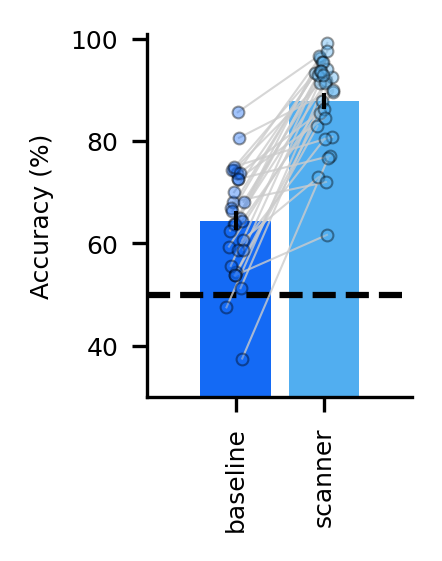

In [12]:
plt.style.use('default')


# load accuracy 
acc_scan = loadmat(dir_results_humanbehav + '/acc_all_scan_granada.mat')['acc_all'][0][0][0]
acc_base = loadmat(dir_results_humanbehav + '/acc_all_training_granada.mat')['acc_all'][0][0][0][0][0][1] # 0 train 1 test 2 long train
badsubs = np.asarray([19,28])-1
acc_scan = np.delete(acc_scan,badsubs).T[np.newaxis,:]

# acc 
cm = 1/2.54
mm = cm/10
plt.figure(figsize=(40*mm,50*mm),dpi=300)
plot_bars_humandata(acc_base,acc_scan)
_ = plt.yticks(np.arange(0,1.2,.2),labels=(np.arange(0,1.2,.2)*100).astype('int'),fontsize=6)
plt.ylim((.3,1.01))
_= plt.ylabel('Accuracy (%)',fontsize=6)
plt.plot([0,3],[.5,.5],'k--')
plt.tight_layout()

## 1D: Human Choice Patterns

/tmp/ipykernel_25516/2314837865.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = cbar.ax.set_yticklabels([0,.2,.4,.6,.8,1],fontsize=6)


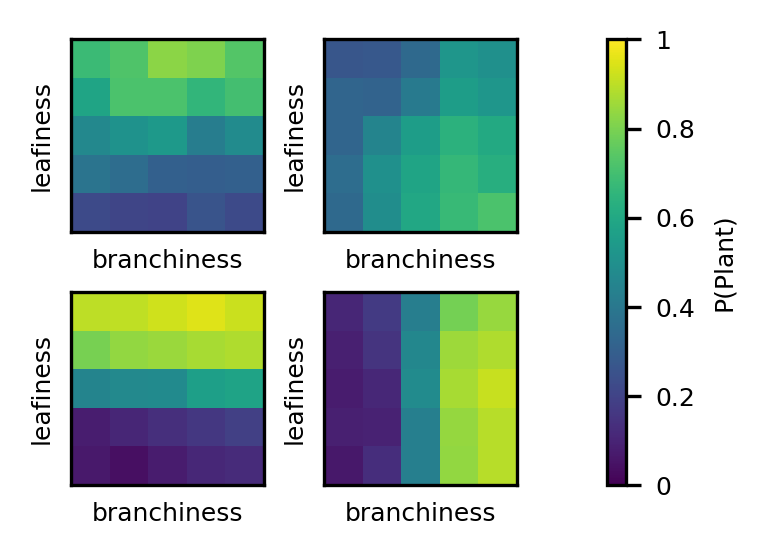

In [8]:
data_train = loadmat(dir_results_humanbehav + 'cmats_train.mat')
data_scan = loadmat(dir_results_humanbehav + 'cmats_scan.mat')
cm = 1/2.54
mm = cm/10
fig = plt.figure(figsize=(65*mm,50*mm),dpi=300)
grid = AxesGrid(fig, 111, nrows_ncols=(2,2),axes_pad=0.2, cbar_mode='single',cbar_location='right',cbar_pad=0.3,label_mode='all')


im = grid[0].imshow(np.flipud(data_train['cmat_north'].mean(axis=0)))
im.set_clim(0,1)
set_choicemat_axlabels(grid[0])
im = grid[1].imshow(np.flipud(data_train['cmat_south'].mean(axis=0)))
im.set_clim(0,1)
set_choicemat_axlabels(grid[1])
im = grid[2].imshow(np.flipud(data_scan['cmat_north'].mean(axis=0)))
im.set_clim(0,1)
set_choicemat_axlabels(grid[2])
im = grid[3].imshow(np.flipud(data_scan['cmat_south'].mean(axis=0)))
im.set_clim(0,1)
set_choicemat_axlabels(grid[3])


cbar = grid.cbar_axes[0].colorbar(im)
_ = cbar.ax.set_yticklabels([0,.2,.4,.6,.8,1],fontsize=6)
_ = cbar.ax.set_ylabel('P(Plant)',fontsize=6)

# plt.tight_layout()


## 1E: Human Psychophysical Model

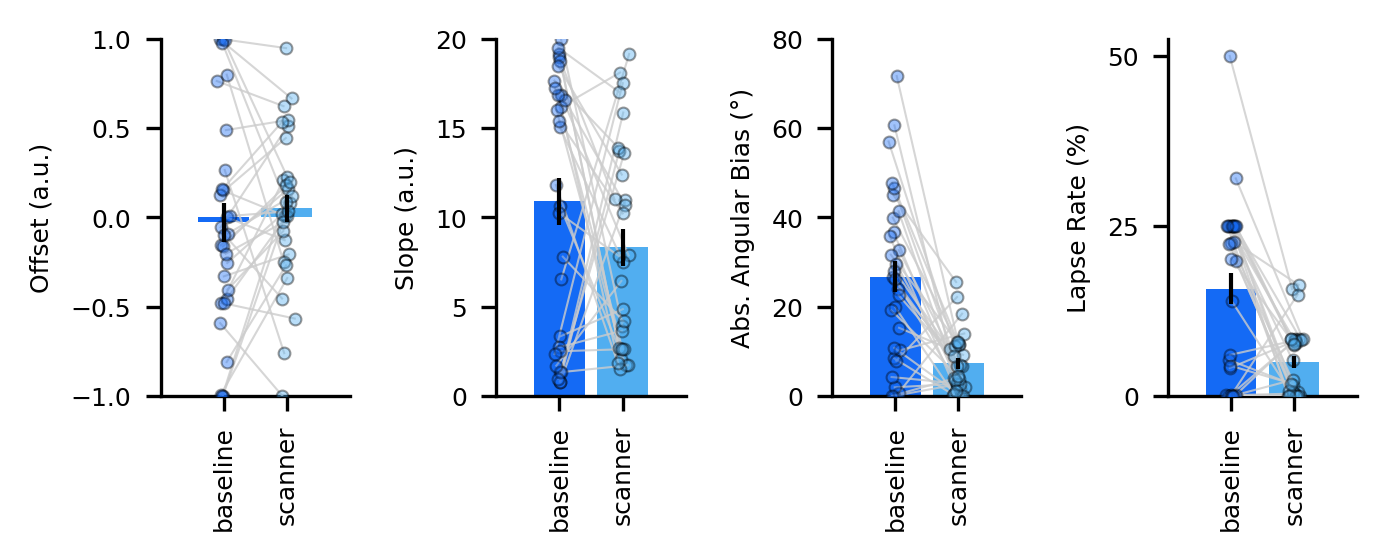

In [15]:
data_base = loadmat(dir_results_humanbehav + 'choicemodel_train.mat')
data_scan = loadmat(dir_results_humanbehav + 'choicemodel_scan.mat')
keys = ['lapse','bias','offset','slope']
badsubs = np.asarray([19,28])-1
for k in keys:
    data_scan[k] = np.delete(data_scan[k],badsubs)[:,np.newaxis].T

cm = 1/2.54
mm = cm/10
fig = plt.figure(figsize=(120*mm,50*mm),dpi=300)
# offset
plt.subplot(1,4,1)
plot_bars_humandata(data_base['offset'].T,data_scan['offset'])
_ = plt.yticks(np.arange(-1,1.1,.5),fontsize=6)
_= plt.ylabel('Offset (a.u.)',fontsize=6)
plt.ylim((-1,1))

# slope 
plt.subplot(1,4,2)
plot_bars_humandata(data_base['slope'].T,data_scan['slope'])
_ = plt.yticks(np.arange(0,21,5),fontsize=6)
_= plt.ylabel('Slope (a.u.)',fontsize=6)
plt.ylim((0,20))

# angular bias 
plt.subplot(1,4,3)
plot_bars_humandata(np.abs(data_base['bias'].T),np.abs(data_scan['bias']))
plt.yticks(np.arange(0,81,20),fontsize=6)
_= plt.ylabel('Abs. Angular Bias (°)',fontsize=6)

# lapse rate
plt.subplot(1,4,4)
plot_bars_humandata(data_base['lapse'].T,data_scan['lapse'])
_= plt.ylabel('Lapse Rate (%)',fontsize=6)
_ = plt.yticks(np.arange(0,0.6,.25),labels=(np.arange(0,0.6,.25)*100).astype('int'),fontsize=6)

plt.tight_layout()

## 1F: Model RSA: Behaviouur

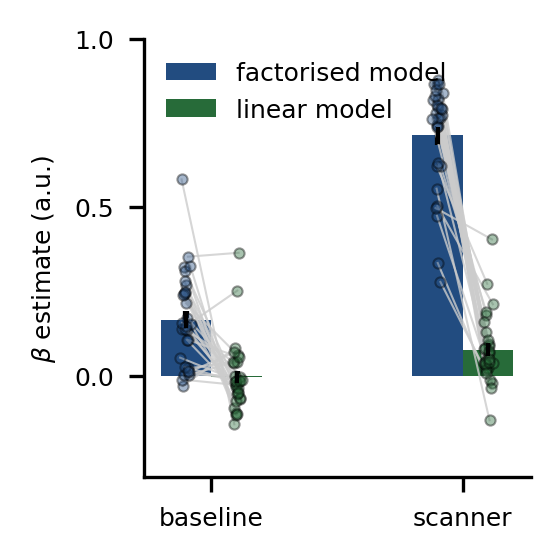

In [17]:
betas_train = loadmat(dir_results_humanbehav + 'betas_3Dvs2D_training_granada.mat')['betas_day1'][0][0][0][0][0][0]
betas_scan = loadmat(dir_results_humanbehav + 'betas_3Dvs2D_scan_granada.mat')['betas_scan'][0][0][0][0][0][0]
plt.close()
N_SUBS = betas_train.shape[0]
badsubs = np.asarray([19,28])-1
betas_scan = np.delete(betas_scan,badsubs,axis=0)

mm = 1/25.4
plt.figure(figsize=(50*mm,50*mm),dpi=300)
width=0.2
idx1a = np.ones((1,N_SUBS))+np.random.randn(1,N_SUBS)*1e-2-width/2
idx1b = np.ones((1,N_SUBS))+np.random.randn(1,N_SUBS)*1e-2+width/2

idx2a = 2*np.ones((1,N_SUBS))+np.random.randn(1,N_SUBS)*1e-2-width/2
idx2b = 2*np.ones((1,N_SUBS))+np.random.randn(1,N_SUBS)*1e-2+width/2

b1=  plt.bar(1-width/2,betas_train[:,0].mean(0),width=width,yerr=betas_train[:,0].std(0)/(N_SUBS**.5),color=(34/255, 76/255, 128/255))
plt.scatter(idx1a,betas_train[:,0],s=6,alpha=0.4,edgecolors='k',color=(34/255, 76/255, 128/255),zorder=4,linewidth=.5)
plt.errorbar(1-width/2,betas_train[:,0].mean(0),linewidth=1,linestyle='None',yerr=betas_train[:,0].std(0)/(N_SUBS**.5),color='k',zorder=6)

b2 = plt.bar(1+width/2,betas_train[:,1].mean(0),width=width,yerr=betas_train[:,1].std(0)/(N_SUBS**.5),color=(39/255, 107/255, 57/255))
plt.scatter(idx1b,betas_train[:,1],s=6,alpha=0.4,edgecolors='k',color=(39/255, 107/255, 57/255),zorder=4,linewidth=.5)
plt.errorbar(1+width/2,betas_train[:,1].mean(0),linewidth=1,linestyle='None',yerr=betas_train[:,1].std(0)/(N_SUBS**.5),color='k',zorder=6)
plt.plot(np.concatenate((idx1a,idx1b),axis=0),betas_train.T,color=(.8, .8, .8),alpha=.8,linewidth=.5)


plt.bar(2-width/2,betas_scan[:,0].mean(0),width=width,yerr=betas_scan[:,0].std(0)/(betas_scan.shape[0]**.5),color=(34/255, 76/255, 128/255))
plt.scatter(idx2a,betas_scan[:,0],s=6,alpha=0.4,edgecolors='k',color=(34/255, 76/255, 128/255),zorder=4,linewidth=.5)
plt.errorbar(2-width/2,betas_scan[:,0].mean(0),linewidth=1,linestyle='None',yerr=betas_train[:,0].std(0)/(N_SUBS**.5),color='k',zorder=6)

plt.bar(2+width/2,betas_scan[:,1].mean(0),width=width,yerr=betas_scan[:,1].std(0)/(betas_scan.shape[0]**.5),color=(39/255, 107/255, 57/255))
plt.scatter(idx2b,betas_scan[:,1],s=6,alpha=0.4,edgecolors='k',color=(39/255, 107/255, 57/255),zorder=4,linewidth=.5)
plt.errorbar(2+width/2,betas_scan[:,1].mean(0),linewidth=1,linestyle='None',yerr=betas_scan[:,1].std(0)/(N_SUBS**.5),color='k',zorder=6)
plt.plot(np.concatenate((idx2a,idx2b),axis=0),betas_scan.T,color=(.8, .8, .8),alpha=.8,linewidth=.5)

plt.xticks(fontsize=6,ticks=[1,2],labels=['baseline','scanner'],rotation=0)
plt.yticks(fontsize=6)
# sns.despine()
plt.legend([b1,b2],['factorised model','linear model'],loc=2,frameon=False,fontsize=6)
plt.ylim((-0.3,1))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel(r'$\beta$ estimate (a.u.)',fontsize=6)
plt.tight_layout()

# Figure 2

## 2B: Weight Norms & Relative Change: Input Weights

input weights:
endpoint weight  KruskalResult(statistic=235.2697095435684, pvalue=3.7656873348591713e-47)
relative weight change  KruskalResult(statistic=234.50922544951595, pvalue=5.46381671837111e-47)


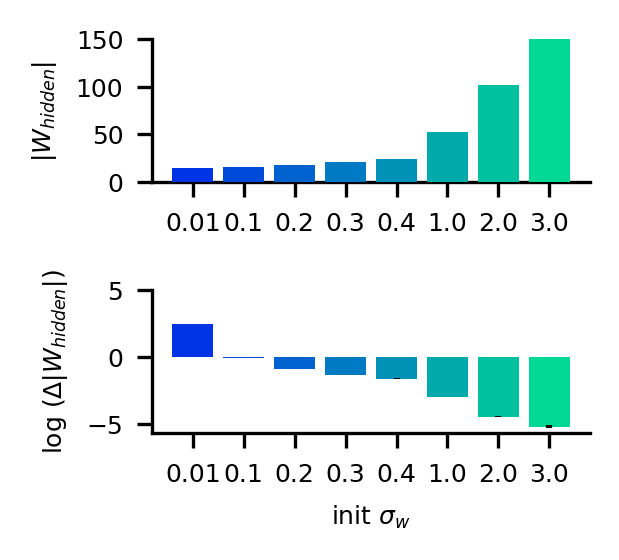

In [27]:
%matplotlib inline
SCALE_WHXS = np.asarray([1e-2,1e-1,2e-1,3e-1,4e-1,1,2,3])
N_FACTORS = len(SCALE_WHXS)
scale_labels = [str(ii) for ii in SCALE_WHXS]


# open results (was 'results_nnet_main_withacc_withmlp_stepscaled.pickle)
with open(dir_results_simus + 'results_mlp_main.pkl','rb') as f:
        results = pickle.load(f)

ws = (results['w_relchange_hxs'][:,:,-1]+results['w_relchange_hxc'][:,:,-1])/2

N_RUNS = ws.shape[1]



mm = 1/25.4
fig = plt.figure(figsize=(55*mm,50*mm),dpi=300)

plt.subplot(2,1,1)

norms = np.empty((8,N_RUNS))
cols = cm.winter(np.linspace(.2,.85,8))
for ii in range(8):
    for jj in range(N_RUNS):
        norms[ii,jj] = np.linalg.norm(np.concatenate((results['all_w_hxs'][ii,jj,:,:].flatten(),results['all_w_hxc'][ii,jj,:,:].flatten()),axis=0))

plot_norms(norms,'Endpoint Norms, input weights',SCALE_WHXS,zorder=3,colors=cols)

plt.xticks(ticks=np.arange(0,len(SCALE_WHXS)),labels=scale_labels,fontsize=6)
plt.yticks(ticks=np.arange(0,161,50),fontsize=6)
plt.ylim(0,150)
plt.ylabel(r'$\| W_{hidden}\|$',fontsize=6)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
lims = plt.xlim()
plt.xlim(lims)
plt.tight_layout()


plt.subplot(2,1,2)
for ii in range(ws.shape[0]):
    plt.bar(ii,np.mean(np.log(np.abs(ws[ii,:])),0),yerr=np.std(np.log(np.abs(ws[ii,:])),0)/np.sqrt(N_RUNS),zorder=3,color=cols[ii,:])
plt.xticks(ticks=np.arange(0,len(SCALE_WHXS)),labels=scale_labels,fontsize=6)
plt.yticks(ticks=np.arange(-5,5.1,5),fontsize=6)
plt.ylabel(r'log $\left(\Delta\|W_{hidden}\|\right)$',fontsize=6)
plt.xlabel(r'init $\sigma_{w}$',fontsize=6)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()

print('input weights:')
print(f'endpoint weight  {kruskal(*norms)}')
print(f'relative weight change  {kruskal(*ws)}')


## 2C: Weight Norms & Relative Change: Output Weights

output weights:
endpoint weight  KruskalResult(statistic=191.50015214384484, pvalue=7.226195078389681e-38)
relative weight change  KruskalResult(statistic=172.0773997233747, pvalue=9.15545817987887e-34)


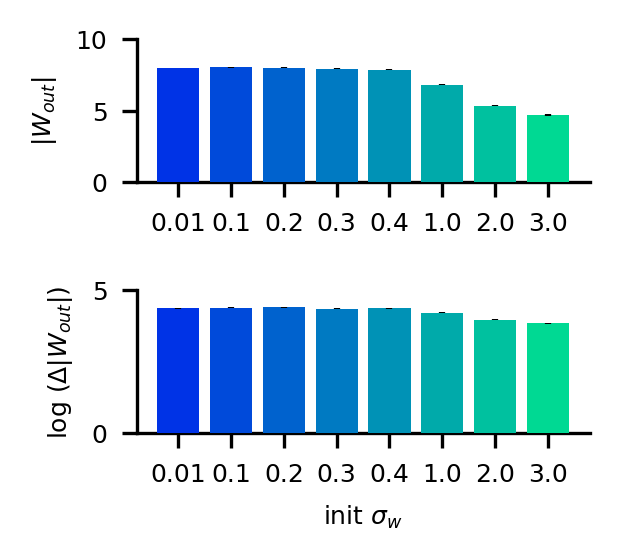

In [28]:
# ditto for output weights 

ws = results['w_relchange_yh'][:,:,-1]
N_RUNS = ws.shape[1]


mm = 1/25.4
fig = plt.figure(figsize=(55*mm,50*mm),dpi=300)

plt.subplot(2,1,1)

norms = np.empty((8,N_RUNS))
cols = cm.winter(np.linspace(.2,.85,8))
for ii in range(8):
    for jj in range(N_RUNS):
        norms[ii,jj] = np.linalg.norm(results['all_w_yh'][ii,jj,:,:].flatten())

plot_norms(norms,'Endpoint Norms, all weights',SCALE_WHXS,zorder=3,colors=cols)
# plt.xticks(ticks=np.arange(0,len(SCALE_WHXS)),labels=[],fontsize=6)
plt.xticks(ticks=np.arange(0,len(SCALE_WHXS)),labels=scale_labels,fontsize=6)
plt.yticks(ticks=np.arange(0,11,5),fontsize=6)
plt.ylabel(r'$\| W_{out}\|$',fontsize=6)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
lims = plt.xlim()
plt.xlim(lims)
plt.tight_layout()


plt.subplot(2,1,2)
for ii in range(ws.shape[0]):
    plt.bar(ii,np.mean(np.log(np.abs(ws[ii,:])),0),yerr=np.std(np.log(np.abs(ws[ii,:])),0)/np.sqrt(N_RUNS),zorder=3,color=cols[ii,:])
plt.xticks(ticks=np.arange(0,len(SCALE_WHXS)),labels=scale_labels,fontsize=6)
plt.yticks(fontsize=6)
plt.yticks(ticks=np.arange(0,6,5))
plt.ylabel(r'log $\left(\Delta\|W_{out}\|\right)$',fontsize=6)
plt.xlabel(r'init $\sigma_{w}$',fontsize=6)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()


print('output weights:')
print(f'endpoint weight  {kruskal(*norms)}')
print(f'relative weight change  {kruskal(*ws)}')


## 2E: PCA,Explained Variance

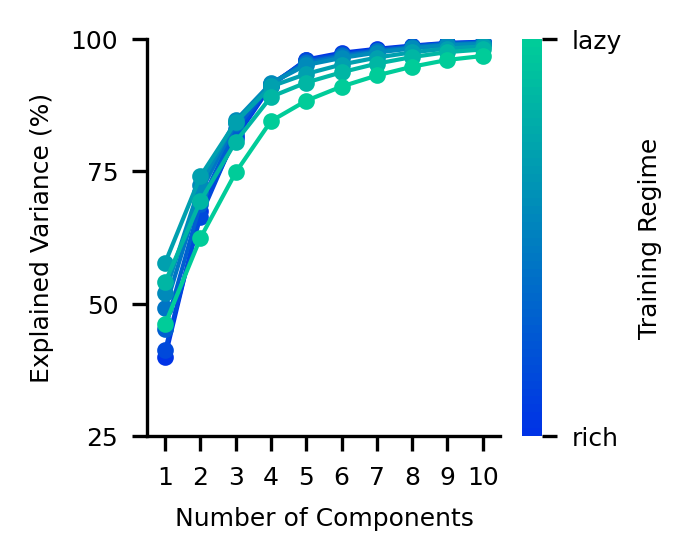

In [29]:
nmax=10 # how many pcs to show

# calculate endpoint norms
norms = np.empty((8,N_RUNS))
for ii in range(8):
    for jj in range(N_RUNS):
        norms[ii,jj] = np.linalg.norm(np.concatenate((results['all_w_hxs'][ii,jj,:,:].flatten(),results['all_w_hxc'][ii,jj,:,:].flatten(),results['all_w_yh'][ii,jj,:,:].flatten()),axis=0))

norms_flt = np.round(np.mean(norms,1),0).astype('int')
norms = ['norm='+str(np.round(ii).astype('int')) for ii in norms_flt]


# Cumulative Explained Variance
cols = cm.winter(np.linspace(.2,.8,8))
cmap_new = mpl.colors.ListedColormap(cm.winter(np.linspace(.2,.8,50)))

mm = 1/25.4
fig = plt.figure(figsize=(60*mm,50*mm),dpi=300)
for ii in range(cols.shape[0]):
    plt.errorbar(np.arange(1,nmax+1),np.mean(np.cumsum(results['svd_scree'][ii,:,:nmax],1),0),color=cols[ii,:],marker='.',yerr=np.std(np.cumsum(results['svd_scree'][ii,:,:nmax],1),0)/np.sqrt(results['svd_scree'].shape[1]),linewidth=1)

plt.xlabel('Number of Components',fontsize=6)
plt.ylabel('Explained Variance (%)',fontsize=6) 

# axis labels
plt.yticks(ticks=np.arange(.0,1.25,.25))
plt.yticks(ticks=np.arange(.0,1.25,.25), labels=(plt.yticks()[0]*100).astype('int'),fontsize=6)

plt.xlim((0.5,nmax+0.5))
plt.xticks(ticks=np.arange(1,nmax+1),fontsize=6)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# add colorbar
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap_new,norm=norm)
cb = plt.colorbar(sm,ticks=[0,1])
cb.ax.set_yticklabels([norms_flt[0],norms_flt[-1]])
cb.ax.set_yticklabels(['rich','lazy'],fontsize=6)
cb.ax.set_ylabel('Training Regime',fontsize=6)
cb.outline.set_visible(False)

_ = plt.ylim((.25,1))

plt.tight_layout()

## 2F: PCA, Accuracy

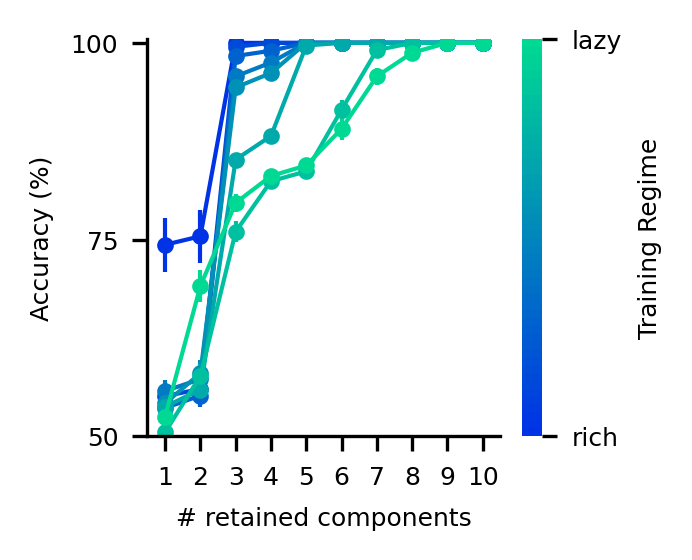

In [30]:
nmax=10

# Accuracy

mm = 1/25.4
fig = plt.figure(figsize=(60*mm,50*mm),dpi=300)

cols = cm.winter(np.linspace(.2,.85,8))

for ii in range(cols.shape[0]):
    plt.errorbar(np.arange(1,nmax+1),np.mean(results['svd_acc'][ii,:,:nmax],0),color=cols[ii,:],marker='.',yerr=np.std(results['svd_acc'][ii,:,:nmax],0)/np.sqrt(results['svd_acc'].shape[1]),linewidth=1)
plt.xlabel('# retained components',fontsize=6)
plt.ylabel('Accuracy (%)',fontsize=6) 
plt.xticks(ticks=np.arange(1,nmax+1,1),fontsize=6)



cols = cm.winter(np.linspace(.2,.85,8))
cmap_new = mpl.colors.ListedColormap(cm.winter(np.linspace(.2,.85,50)))
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap_new,norm=norm)


cb = plt.colorbar(sm,ticks=[0,1])
cb.ax.set_yticklabels(['rich','lazy'],fontsize=6)
cb.ax.set_ylabel('Training Regime',fontsize=6)

cb.outline.set_visible(False)

plt.yticks(ticks=np.arange(0.5,1.25,.25),labels=np.arange(50,125,25).astype('int'),fontsize=6)
plt.ylim((0.5,1.005))
plt.xlim((.5,nmax+.5))


ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()

## 2G: Convergence Speed

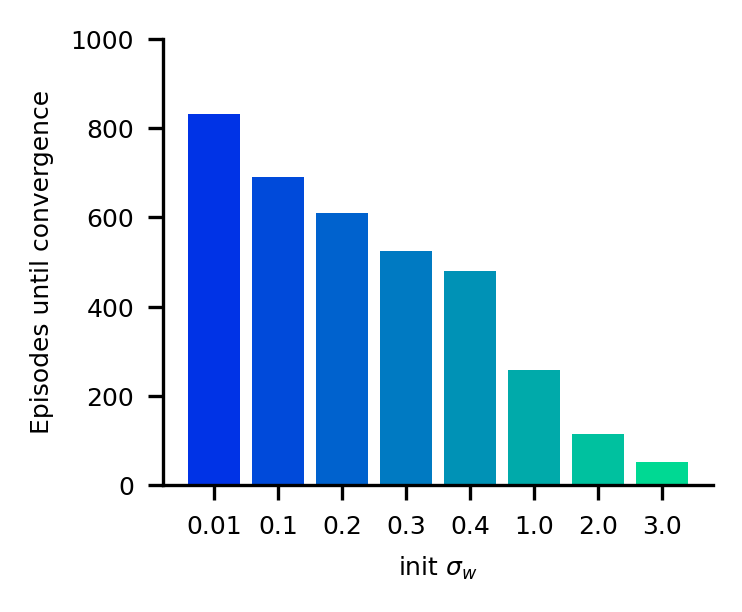

convergence rates rich vs lazy: Ttest_indResult(statistic=125.84654660356627, pvalue=2.0974804978749266e-72)


<Figure size 432x288 with 0 Axes>

In [34]:

cols = cm.winter(np.linspace(.2,.85,8))
is_ceil = []
mm = 1/25.4
fig = plt.figure(figsize=(60*mm,50*mm),dpi=300)
for ii in range(N_FACTORS):
    this_conv = np.where(np.mean(results['all_accuracies'][ii,:,:],0)==1)[0][0]
    is_ceil.append(this_conv)
    # plt.barh(ii,this_conv,color=cols[ii,:])    
    plt.bar(ii,this_conv,color=cols[ii,:])    


plt.xlabel('init $\sigma_w$',fontsize=6)
plt.ylabel('Episodes until convergence',fontsize=6)
plt.xticks(ticks=np.arange(0,8),labels=SCALE_WHXS,fontsize=6)
ticks = plt.yticks()[0]
plt.yticks(ticks=ticks,fontsize=6)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()
plt.tight_layout()

is_ceil = []
for ii in range(N_FACTORS):
    this_conv = np.empty(30)
    for r in range(30):
        this_conv[r] = np.where(results['all_accuracies'][ii,r,:]==1)[0][0]    
    is_ceil.append(this_conv)
print(f'convergence rates rich vs lazy: {ttest_ind(is_ceil[0],is_ceil[-1])}')

## 2H: Added Noise

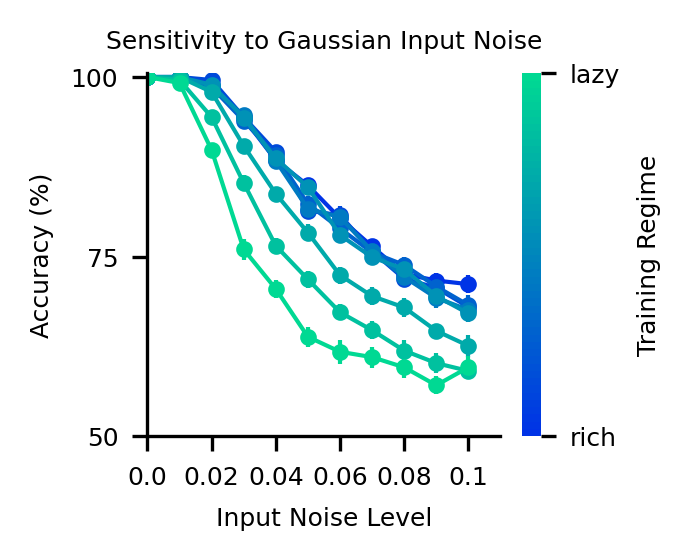

In [36]:

with open(dir_results_simus + 'results_mlp_noise.pkl','rb') as f:
    results = pickle.load(f)


norms = np.empty((8,30))
for ii in range(8):
    for jj in range(30):
        norms[ii,jj] = np.linalg.norm(np.concatenate((results['all_w_hxs'][ii,jj,:,:].flatten(),results['all_w_hxc'][ii,jj,:,:].flatten(),results['all_w_yh'][ii,jj,:,:].flatten()),axis=0))
norms_flt = np.round(np.mean(norms,1),0).astype('int')
norms = ['norm='+str(np.round(ii).astype('int')) for ii in norms_flt]


mm = 1/25.4
fig = plt.figure(figsize=(60*mm,50*mm),dpi=300)

cols = cm.winter(np.linspace(.2,.85,8))
cmap_new = mpl.colors.ListedColormap(cm.winter(np.linspace(.2,.85,50)))

for ii in range(cols.shape[0]):
    plt.errorbar(np.arange(len(results['xlabel_noise'])),np.mean(results['acc_noise'][ii,:,:],0),color=cols[ii,:],marker='.',yerr=(np.std(results['acc_noise'][ii,:,:],0)/np.sqrt(results['acc_noise'].shape[1])).ravel(),linewidth=1)

plt.xlabel('Input Noise Level',fontsize=6)
plt.ylabel('Accuracy (%)',fontsize=6) 
plt.title('Sensitivity to Gaussian Input Noise',fontsize=6)


norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap_new,norm=norm)
cb = plt.colorbar(sm,ticks=[0,1])
cb.ax.set_yticklabels(['rich','lazy'],fontsize=6)
cb.ax.set_ylabel('Training Regime',fontsize=6)

cb.outline.set_visible(False)

plt.ylim((0.5,1.01))


plt.yticks(ticks=np.arange(0.5,1.25,.25),labels=np.arange(50,125,25).astype('int'),fontsize=6)
plt.ylim((0.5,1.005))
plt.xticks(ticks=np.arange(0,len(results['xlabel_noise']),2),labels=results['xlabel_noise'][0::2],fontsize=6)


ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xlim([0,len(results['xlabel_noise'])])

plt.tight_layout()

# Figure 3

## 3A,B: Nnet MDS

In [39]:
y = results['all_y_hidden']
print(y.shape)
rdms = np.empty((2,N_RUNS,50,50))
for ii in range(N_RUNS):
    rdms[0,ii,:,:] = squareform(pdist(y[0,ii,:,:].T,metric='euclidean'))
for ii in range(N_RUNS):
    rdms[1,ii,:,:] = squareform(pdist(y[-1,ii,:,:].T,metric='euclidean'))

labels = ['feature learning regime', 'lazy learning regime']
fig=plt.figure(1,figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
for ii in range(2):
    plt.subplot(1,2,ii+1)
    plt.imshow(np.mean(rdms[ii,:,:,:],0))
    plt.title(labels[ii])


embedding = MDS(n_components=3,n_init=10,max_iter=10000,metric=True)

xyz_rich = embedding.fit_transform(np.mean(rdms[0,:,:,:],0))
xyz_lazy = embedding.fit_transform(np.mean(rdms[1,:,:,:],0))
embeddings = {'rich':xyz_rich, 'lazy':xyz_lazy}


(8, 30, 100, 50)


/home/timo/anaconda3/envs/pytorch19/lib/python3.8/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/home/timo/anaconda3/envs/pytorch19/lib/python3.8/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


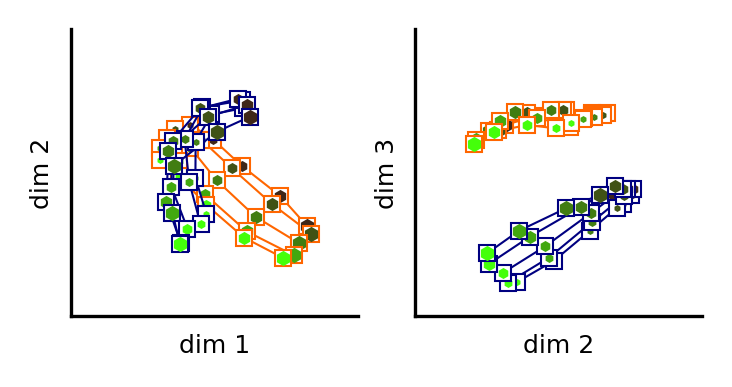

In [42]:
%matplotlib inline
# plot rich regime
# with open('mds_embeddings.pickle','rb') as f:
#         embeddings = pickle.load(f)
theta_x = 0
theta_y = 0
theta_z = 0

xyz_rot = rotate(embeddings['rich'],theta_x,axis='x')
xyz_rot = rotate(xyz_rot,theta_y,axis='y')
xyz_rot = rotate(xyz_rot,theta_z,axis='z')

plt.close()
mm = 1/25.4
fig = plt.figure(2,figsize=(69*mm, 33*mm), dpi= 300, facecolor='w', edgecolor='k')

plot_MDS_embeddings_2D(xyz_rot,fig,fig_id=2,axlims=2.5)


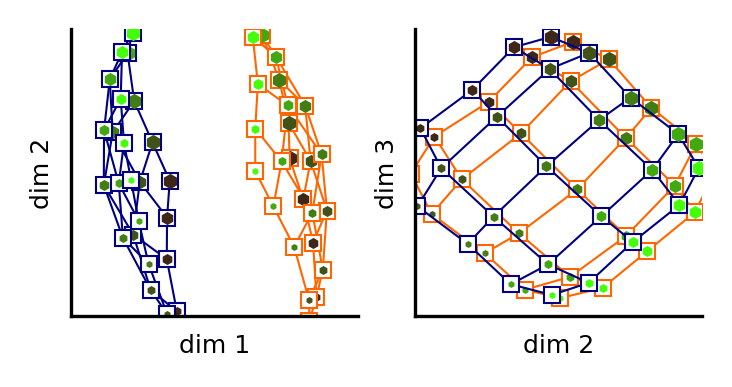

In [43]:
# plot lazy regime
# with open('mds_embeddings.pickle','rb') as f:
#         embeddings = pickle.load(f)
theta_x = 0
theta_y = 0
theta_z = 0

xyz_rot = rotate(embeddings['lazy'],theta_x,axis='x')
xyz_rot = rotate(xyz_rot,theta_y,axis='y')
xyz_rot = rotate(xyz_rot,theta_z,axis='z')

plt.close()
mm = 1/25.4
fig = plt.figure(3,figsize=(69*mm, 33*mm), dpi= 300, facecolor='w', edgecolor='k')

plot_MDS_embeddings_2D(xyz_rot,fig,fig_id=3,axlims=4)


## 3C: Nnet RSA

ttest orth: rich > lazy: Ttest_indResult(statistic=20.25806079466091, pvalue=5.468391398844848e-28), ttest grid: rich < lazy: Ttest_indResult(statistic=-29.014342229443137, pvalue=3.1699640896532264e-36)
ttest grid> par main: Ttest_indResult(statistic=74.6994715305709, pvalue=2.3838805319974046e-59), ttest orth > par main: Ttest_indResult(statistic=82.614427602903, pvalue=7.306743776535913e-62)


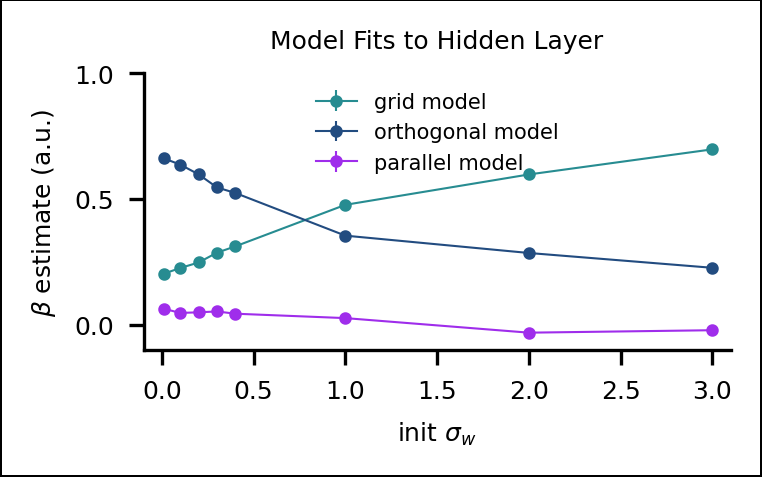

In [45]:

with open(dir_results_simus + 'results_mlp_main.pkl','rb') as f:
        results = pickle.load(f)

ws = results['w_relchange_hxs'][:,:,-1]
N_RUNS = ws.shape[1]
_, dmat,xyz = gen_modelrdms(monitor=0)

coeffs,c_mu,c_err = stats_fit_rdms(dmat,results['all_y_hidden'])

fig=plt.figure(figsize=(67*(1/25.4), 43*(1/25.4)), dpi=300, facecolor='w', edgecolor='k',linewidth=.5)

  

plot_rsa_fits(c_mu,c_err,runvalue=SCALE_WHXS,runlabel=r'init $\sigma_{w}$',titlestr='Model Fits to Hidden Layer')
plt.ylim((-.1,1))

plt.tight_layout()
c_grid = coeffs[:,:,0]
c_orth = coeffs[:,:,1]
c_par = coeffs[:,:,2]

print(f'ttest orth: rich > lazy: {ttest_ind(c_orth[0],c_orth[-1])}, ttest grid: rich < lazy: {ttest_ind(c_grid[0],c_grid[-1])}')
print(f'ttest grid> par main: {ttest_ind(c_grid.mean(0),c_par.mean(0))}, ttest orth > par main: {ttest_ind(c_orth.mean(0),c_par.mean(0))}')


## 3D,E,F: Nnet Parameterised Model

are compression rates different? kruskal wallis: z=14.0005, p=0.0000
is compression larger in rich than lazy: t=-49.7760, p=0.0000
is compression significant in rich: z=4.7821, p=0.0000
is compression significant in lazy: z=0.0720, p=0.9426
are angles different? kruskal wallis: z=1.9976, p=0.0458
is angles larger in rich than lazy: z=2.8312, p=0.0046
is rotation significantly different from 90 in rich: z=4.7821, p=0.0000
is rotation significantly different from 90 in lazy: z=4.7821, p=0.0000
are offsets different? kruskal wallis: z=8.4022, p=0.0000
is offset larger in rich than lazy: z=2.5651, p=0.0103
is offset significant in rich: z=4.7821, p=0.0000
is offset significant in lazy: z=4.7821, p=0.0000


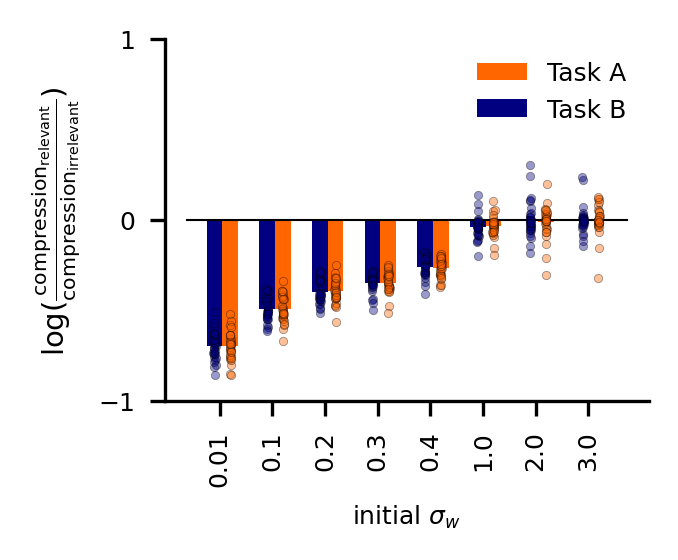

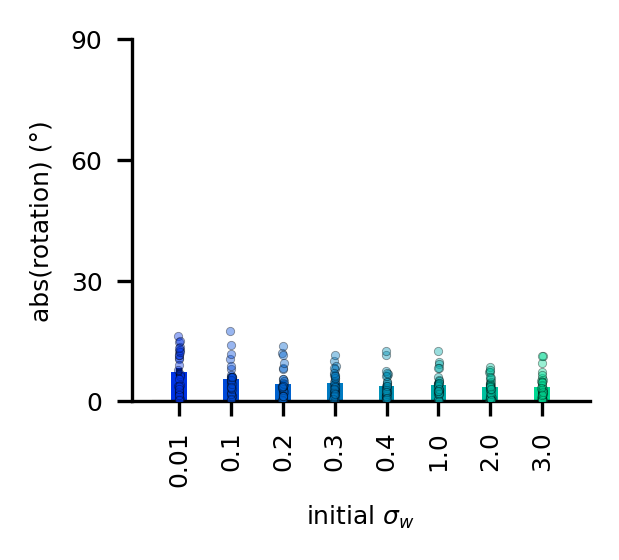

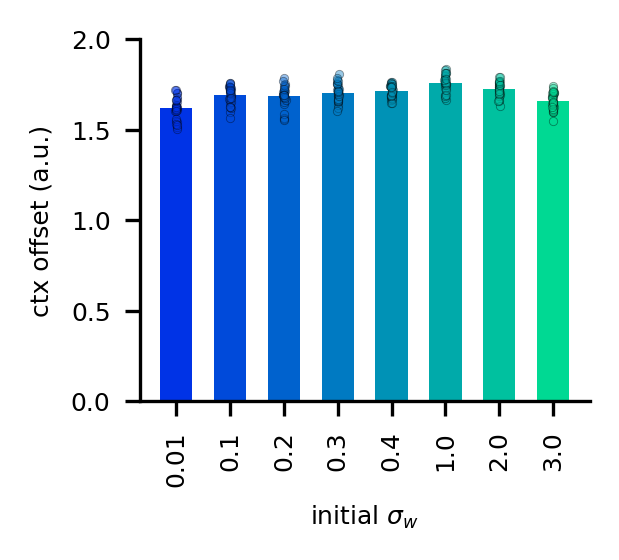

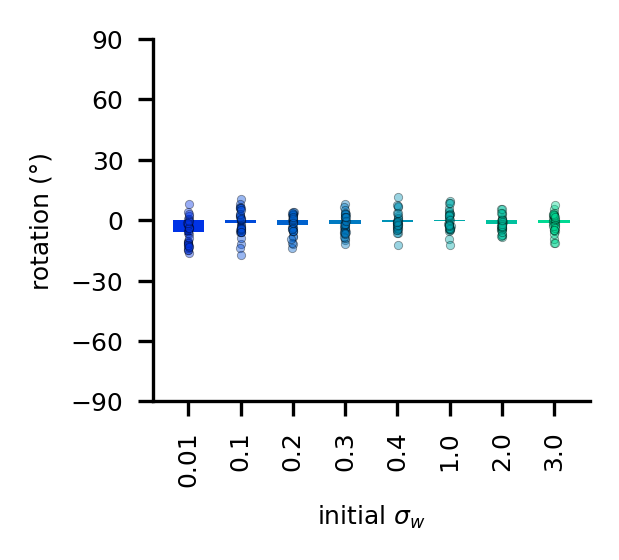

In [51]:
# fit parametrised model to hidden layer patterns 
# thetas = np.empty((8,N_RUNS,6))
# rdms = np.empty((8,N_RUNS,50,50))
# for s in range(8):
#     for r in range(N_RUNS):
#         rdm = squareform(pdist(results['all_y_hidden'][s,r,:,:].T))
#         t = wrapper_fit_param_model(rdm,n_iters=100,para_iters=True)
#         thetas[s,r,:] = t 
#         rdms[s,r,:,:] = squareform(param_rdm_model(t))
# parammod_results = {'thetas':thetas,'rdms':rdms}
# with open('parammod_results.pkl','wb') as f:
#     pickle.dump(parammod_results,f)

from scipy.stats import norm

with open(dir_results_simus + 'parammod_results.pkl','rb') as f:
    data = pickle.load(f)

compression_rates = []
phis = []
offsets = []
for ii in range(len(SCALE_WHXS)):

    data_layer = np.array(data['thetas'])[ii,:,:]
    # north & south task task
    comp_north = np.log(data_layer[:,0]/data_layer[:,2])
    comp_south = np.log(data_layer[:,1]/data_layer[:,3])
    compression_rates.append(np.array(comp_north+comp_south)/2)
    phis.append(data_layer[:,4])
    offsets.append(data_layer[:,5])

z,p = kruskal(*compression_rates)
z = norm.isf(p/2)
print(f'are compression rates different? kruskal wallis: z={z:.4f}, p={p:.4f}')

t,p = ttest_ind(compression_rates[0],compression_rates[-1])
# z = norm.isf(p/2)
print(f'is compression larger in rich than lazy: t={t:.4f}, p={p:.4f}')

z,p = wilcoxon(compression_rates[0])
z = norm.isf(p/2)
print(f'is compression significant in rich: z={z:.4f}, p={p:.4f}')

z,p = wilcoxon(compression_rates[-1])
z = norm.isf(p/2)
print(f'is compression significant in lazy: z={z:.4f}, p={p:.4f}')


z,p = kruskal(*phis)
z = norm.isf(p/2)
print(f'are angles different? kruskal wallis: z={z:.4f}, p={p:.4f}')

z,p = mannwhitneyu(phis[0],phis[-1])
z = norm.isf(p/2)
print(f'is angles larger in rich than lazy: z={z:.4f}, p={p:.4f}')

z,p = wilcoxon(90-phis[0])
z = norm.isf(p/2)
print(f'is rotation significantly different from 90 in rich: z={z:.4f}, p={p:.4f}')

z,p = wilcoxon(90-phis[-1])
z = norm.isf(p/2)
print(f'is rotation significantly different from 90 in lazy: z={z:.4f}, p={p:.4f}')


z,p = kruskal(*offsets)
z = norm.isf(p/2)
print(f'are offsets different? kruskal wallis: z={z:.4f}, p={p:.4f}')

z,p = mannwhitneyu(offsets[0],offsets[-1])
z = norm.isf(p/2)
print(f'is offset larger in rich than lazy: z={z:.4f}, p={p:.4f}')

z,p = wilcoxon(offsets[0])
z = norm.isf(p/2)
print(f'is offset significant in rich: z={z:.4f}, p={p:.4f}')

z,p = wilcoxon(offsets[-1])
z = norm.isf(p/2)
print(f'is offset significant in lazy: z={z:.4f}, p={p:.4f}')


mm = 1/25.4
f1 = plt.figure(1,figsize=(60*mm,50*mm), dpi=300)
f2 = plt.figure(2,figsize=(55*mm,50*mm), dpi=300)
f3 = plt.figure(3,figsize=(55*mm,50*mm), dpi=300)
f4 = plt.figure(4,figsize=(55*mm,50*mm), dpi=300)

cols = cm.winter(np.linspace(.2,.85,8))
for ii in range(len(SCALE_WHXS)):

    data_layer = np.array(data['thetas'])[ii,:,:]

    # plot relative compression
    plt.figure(f1.number)
    # north & south task task
    comp_north = np.log(data_layer[:,0]/data_layer[:,2])
    comp_south = np.log(data_layer[:,1]/data_layer[:,3])
    bn = plt.bar(ii-0.1,np.mean(comp_north),yerr=np.std(comp_north)/(len(comp_north)**.5),width=0.3,linewidth=2,color=(0,0,.5),zorder=1)
    bs = plt.bar(ii+0.2,np.mean(comp_south),yerr=np.std(comp_south)/(len(comp_south)**.5),width=0.3,linewidth=2,color=(255/255,102/255,0),zorder=1)
    plt.scatter(np.repeat((ii-0.1),len(comp_north))+np.random.randn(len(comp_north))*0.01,comp_north,s=4,color=(0,0,.5),alpha=.4,zorder=3,edgecolors='k',linewidth=0.2)
    plt.scatter(np.repeat((ii+0.2),len(comp_south))+np.random.randn(len(comp_north))*0.01,comp_south,s=4,color=(255/255,102/255,0),alpha=.4,zorder=3,edgecolors='k',linewidth=0.2)
    spiceUp_figure(f1,SCALE_WHXS)
    plt.ylabel(r'$\mathrm{log(\frac{compression_{relevant}}{compression_{irrelevant}})}$',fontsize=7)
    # plt.title('Estimated Compression \n Relevant vs Irrelevant Dimension',fontsize=6)
    plt.legend([bs,bn],['Task A','Task B'],frameon=False,loc=1,fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.xlabel(r'initial $\sigma_w$',fontsize=6)

    
    # plot estimated angle (abs)
    plt.figure(f2.number)
    phi_est = np.abs(data_layer[:,4])
    bph = plt.bar(ii,np.mean(phi_est),yerr=np.std(phi_est)/(len(phi_est)**.5),width=0.3,color=cols[ii],zorder=1)
    plt.scatter(np.repeat(ii,len(phi_est))+np.random.randn(len(comp_north))*0.01,phi_est,color=cols[ii],alpha=0.4,zorder=3,s=4,edgecolors='k',linewidth=0.2)
    spiceUp_figure(f2,SCALE_WHXS)
    plt.ylabel('abs(rotation) (°)',fontsize=6)
    # plt.title('Estimated Rotation \n from Stimulus to Response Space',fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(ticks=[0,30,60,90],fontsize=6)
    plt.ylim([0,90])
    plt.xlabel(r'initial $\sigma_w$',fontsize=6)

    # estimated ctx offset 
    plt.figure(f3.number)
    ctx_est = data_layer[:,5]
    bctx = plt.bar(ii,np.mean(ctx_est),yerr=np.std(ctx_est)/(len(ctx_est)**.5),width=0.6,color=cols[ii])
    plt.scatter(np.repeat(ii,len(ctx_est))+np.random.randn(len(comp_north))*0.01,ctx_est,color=cols[ii],alpha=0.4,zorder=3,s=4,edgecolors='k',linewidth=0.2)
    spiceUp_figure(f3,SCALE_WHXS)
    plt.ylabel('ctx offset (a.u.)',fontsize=6)
    # plt.title('Estimated Context Offset Parameter',fontsize=6)
    plt.ylim([0,2])
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.xlabel(r'initial $\sigma_w$',fontsize=6)

    # plot estimated angle 
    plt.figure(f4.number)
    phi_est = data_layer[:,4]
    bph = plt.bar(ii,np.mean(phi_est),yerr=np.std(phi_est)/(len(phi_est)**.5),width=0.6,color=cols[ii],zorder=1)
    plt.scatter(np.repeat(ii,len(phi_est))+np.random.randn(len(comp_north))*0.01,phi_est,color=cols[ii],alpha=0.4,zorder=3,s=4,edgecolors='k',linewidth=0.2)
    spiceUp_figure(f4,SCALE_WHXS)
    plt.ylabel('rotation (°)',fontsize=6)
    # plt.title('Estimated Rotation \n from Stimulus to Response Space',fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(ticks=[-90,-60,-30,0,30,60,90],fontsize=6)
    plt.ylim([-90,90])
    plt.xlabel(r'initial $\sigma_w$',fontsize=6)


plt.figure(f1.number)
plt.yticks(np.arange(-1,1.1,1)) 
plt.ylim([-1,1])
lims = plt.xlim()
plt.plot(lims,[0,0],'k-',linewidth=.5)
plt.tight_layout()
plt.figure(f2.number)
plt.ylim([0,90])
lims = plt.xlim()
plt.plot(lims,[0,0],'k-',linewidth=.5)
plt.tight_layout()
plt.figure(f3.number)
plt.tight_layout()
plt.figure(f4.number)
plt.tight_layout()
f = plt.gcf()
f.set_dpi(300)

# Figure 4

## 4B: fMRI Parameterised Model 

EVC Compression North: z=2.25, p=0.0242, Compression South: z=4.10, p=0.0000 
EVC Offset: z=4.86, p=0.0000 
EVC Angle: z=1.49, p=0.1364 
PPC Compression North: z=4.80, p=0.0000, Compression South: z=4.84, p=0.0000 
PPC Offset: z=4.86, p=0.0000 
PPC Angle: z=0.53, p=0.5967 
MCC Compression North: z=4.84, p=0.0000, Compression South: z=4.80, p=0.0000 
MCC Offset: z=4.86, p=0.0000 
MCC Angle: z=0.27, p=0.7838 
dlPFC Compression North: z=4.53, p=0.0000, Compression South: z=4.86, p=0.0000 
dlPFC Offset: z=4.86, p=0.0000 
dlPFC Angle: z=1.14, p=0.2557 


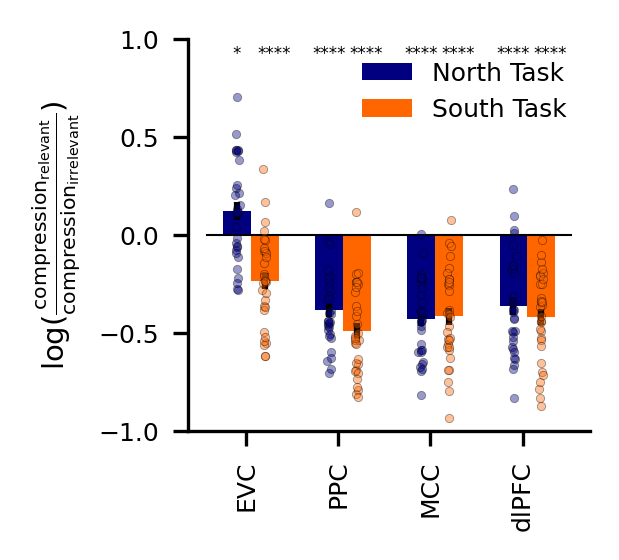

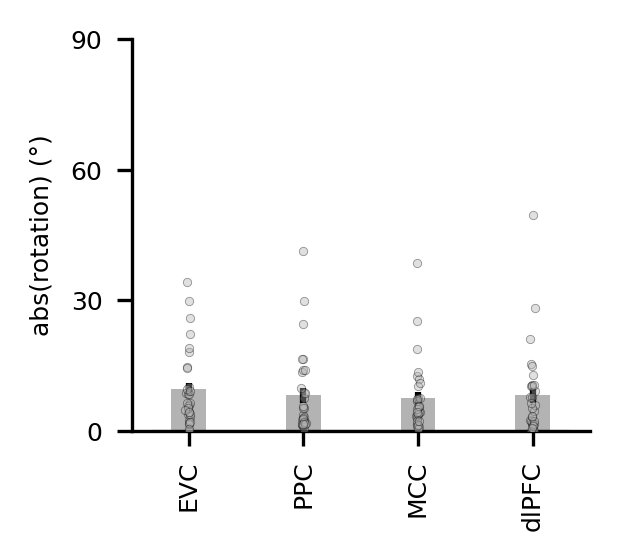

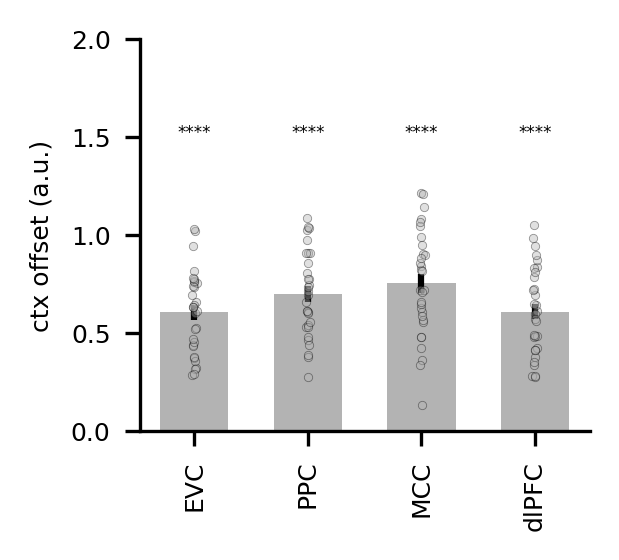

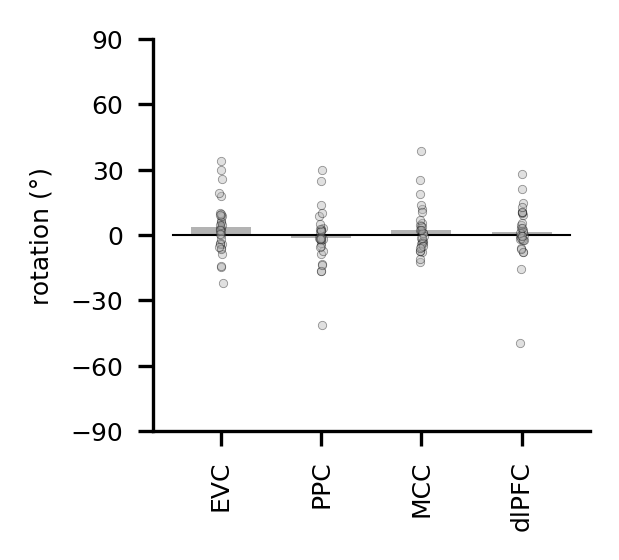

In [3]:
from scipy.stats import wilcoxon, norm

roi_names = ['EVC', 'PPC', 'MCC', 'dlPFC']


data_dir = dir_results_humanfmri + 'ROIs/'
roi_files = ['results_fmincon_avg_leftEVC.mat',
'results_fmincon_avg_PPC.mat',
'results_fmincon_avg_MCC.mat',
'results_fmincon_avg_DLPFC.mat']


mm = 1/25.4
f1 = plt.figure(1,figsize=(55*mm,50*mm), dpi=300)
f2 = plt.figure(2,figsize=(55*mm,50*mm), dpi=300)
f3 = plt.figure(3,figsize=(55*mm,50*mm), dpi=300)
f4 = plt.figure(4,figsize=(55*mm,50*mm), dpi=300)
for ii,nm in enumerate(roi_files):

    
    all_data = loadmat(data_dir + nm)['data']

    # plot relative compression
    plt.figure(f1.number)
    # north & south task task
    comp_north = np.log(all_data[:,0]/all_data[:,2])
    comp_south = np.log(all_data[:,1]/all_data[:,3])
    bn = plt.bar(ii-0.1,np.mean(comp_north),yerr=np.std(comp_north)/(len(comp_north)**.5),width=0.3,linewidth=2,color=(0,0,.5),zorder=1)
    bs = plt.bar(ii+0.2,np.mean(comp_south),yerr=np.std(comp_south)/(len(comp_south)**.5),width=0.3,linewidth=2,color=(255/255,102/255,0),zorder=1)
    plt.scatter(np.repeat((ii-0.1),len(comp_north))+np.random.randn(len(comp_north))*0.01,comp_north,s=4,color=(0,0,.5),alpha=.4,zorder=3,edgecolors='k',linewidth=0.2)
    plt.scatter(np.repeat((ii+0.2),len(comp_south))+np.random.randn(len(comp_north))*0.01,comp_south,s=4,color=(255/255,102/255,0),alpha=.4,zorder=3,edgecolors='k',linewidth=0.2)
    spiceUp_figure(f1,roi_names)
    plt.ylabel(r'$\mathrm{log(\frac{compression_{relevant}}{compression_{irrelevant}})}$',fontsize=7)
    
    plt.legend([bn,bs],['North Task','South Task'],frameon=False,loc=1,fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
   
    
    s,p1 = wilcoxon(comp_north)
    z1 = norm.isf(p1/2)
    s,p2 = wilcoxon(comp_south)
    z2 = norm.isf(p2/2)
    print(f'{roi_names[ii]} Compression North: z={z1:.2f}, p={p1:.4f}, Compression South: z={z2:.2f}, p={p2:.4f} ')
    if np.abs(z1)>1.96:
        if p1 <0.0001:
            ts = '*'*4
        elif p1 <0.001:
            ts = '*'*3
        elif p1<0.01:
            ts = '*'*2
        elif p1<0.05:
            ts = '*'
        plt.text(ii-0.1,0.9,ts,{'fontsize':4,'ha':'center','fontweight':'normal'})
    if np.abs(z2)>1.96:
        if p2 <0.0001:
            ts = '*'*4
        elif p2 <0.001:
            ts = '*'*3
        elif p2<0.01:
            ts = '*'*2
        elif p2<0.05:
            ts = '*'
        plt.text(ii+0.3,0.9,ts,{'fontsize':4,'ha':'center','fontweight':'normal'})
    

    
    # plot estimated angle (abs)
    plt.figure(f2.number)
    phi_est = np.abs(all_data[:,4])
    bph = plt.bar(ii,np.mean(phi_est),yerr=np.std(phi_est)/(len(phi_est)**.5),width=0.3,color=(0.7,0.7,.7),zorder=1)
    plt.scatter(np.repeat(ii,len(phi_est))+np.random.randn(len(comp_north))*0.01,phi_est,color=(0.7,0.7,.7),alpha=0.4,zorder=3,s=4,edgecolors='k',linewidth=0.2)
    spiceUp_figure(f2,roi_names)
    plt.ylabel('abs(rotation) (°)',fontsize=6)
    
    plt.xticks(fontsize=6)
    plt.yticks(ticks=[0,30,60,90],fontsize=6)
    plt.ylim([0,90])

    # estimated ctx offset 
    plt.figure(f3.number)
    ctx_est = all_data[:,5]
    bctx = plt.bar(ii,np.mean(ctx_est),yerr=np.std(ctx_est)/(len(ctx_est)**.5),width=0.6,color=(0.7,0.7,.7))
    plt.scatter(np.repeat(ii,len(ctx_est))+np.random.randn(len(comp_north))*0.01,ctx_est,color=(0.7,0.7,.7),alpha=0.4,zorder=3,s=4,edgecolors='k',linewidth=0.2)
    spiceUp_figure(f3,roi_names)
    plt.ylabel('ctx offset (a.u.)',fontsize=6)
    # plt.title('Estimated Context Offset Parameter',fontsize=6)
    plt.ylim([0,2])
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

     
    s,p1 = wilcoxon(ctx_est)
    z1 = norm.isf(p1/2)
    
    print(f'{roi_names[ii]} Offset: z={z1:.2f}, p={p1:.4f} ')
    if np.abs(z1)>1.96:
        if p1 <0.0001:
            ts = '*'*4
        elif p1 <0.001:
            ts = '*'*3
        elif p1<0.01:
            ts = '*'*2
        elif p1<0.05:
            ts = '*'
        plt.text(ii,1.5,ts,{'fontsize':4,'ha':'center','fontweight':'normal'})

    # plot estimated angle 
    plt.figure(f4.number)
    phi_est = all_data[:,4]
    bph = plt.bar(ii,np.mean(phi_est),yerr=np.std(phi_est)/(len(phi_est)**.5),width=0.6,color=(0.7,0.7,.7),zorder=1)
    plt.scatter(np.repeat(ii,len(phi_est))+np.random.randn(len(comp_north))*0.01,phi_est,color=(0.7,0.7,.7),alpha=0.4,zorder=3,s=4,edgecolors='k',linewidth=0.2)
    spiceUp_figure(f4,roi_names)
    plt.ylabel('rotation (°)',fontsize=6)
    
    plt.xticks(fontsize=6)
    plt.yticks(ticks=[-90,-60,-30,0,30,60,90],fontsize=6)
    plt.ylim([-90,90])
    s,p1 = wilcoxon(phi_est)
    z1 = norm.isf(p1/2)
    
    print(f'{roi_names[ii]} Angle: z={z1:.2f}, p={p1:.4f} ')
    if np.abs(z1)>1.96:
        if p1 <0.0001:
            ts = '*'*4
        elif p1 <0.001:
            ts = '*'*3
        elif p1<0.01:
            ts = '*'*2
        elif p1<0.05:
            ts = '*'
        plt.text(ii,0.9,ts,{'fontsize':4,'ha':'center','fontweight':'normal'})


plt.figure(f1.number)
plt.yticks(np.arange(-1,1.2,.5)) 
plt.ylim([-1,1])
lims = plt.xlim()
plt.plot(lims,[0,0],'k-',linewidth=.5)
plt.tight_layout()
plt.figure(f2.number)
plt.ylim([0,90])
lims = plt.xlim()
plt.plot(lims,[0,0],'k-',linewidth=.5)
plt.tight_layout()
plt.figure(f3.number)
plt.tight_layout()
f = plt.gcf()
f.set_dpi(300)

plt.figure(f4.number)
lims = plt.xlim()
plt.plot(lims,[0,0],'k-',linewidth=.5)
plt.tight_layout()

## 4C: fMRI MDS Visualisations

In [6]:
data_dir = dir_results_humanfmri + '/ROIs/'
# load data 
data = loadmat(data_dir + 'fmincon_rdms.mat')
print(data.keys())
# roi labels 
rois = ['leftEVC','rightEVC','rightPAR','MCC','rightDLPFC']

# rdm = data['rdms_evc_l']
# embedding = MDS(n_components=3,dissimilarity='precomputed',max_iter=10000,metric=True)
# xyz = embedding.fit_transform(rdm)

dict_keys(['__header__', '__version__', '__globals__', 'rdms_dlpfc', 'rdms_evc_l', 'rdms_mcc', 'rdms_ppc'])


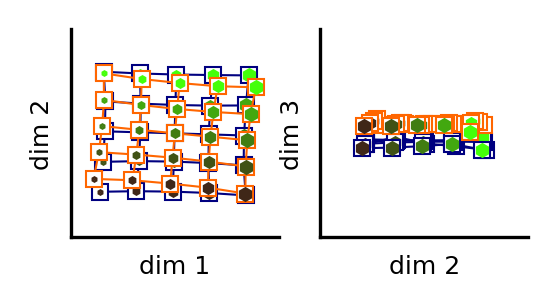

In [7]:
with open(data_dir + 'mds_embedding_leftEVC.pickle','rb') as f:
        xyz = pickle.load(f)
# plot results
%matplotlib inline
xyz_rot = rotate(xyz,0,axis='x')
xyz_rot = rotate(xyz_rot,0,axis='y')
xyz_rot = rotate(xyz_rot,0,axis='z')

mm = 1/25.4
fig = plt.figure(1,figsize=(50*mm, 25*mm), dpi=300, facecolor='w', edgecolor='k')

plot_MDS_embeddings_2D(xyz_rot,fig,fig_id=1,axlims=.5,flipdims=True,flipcols=True)

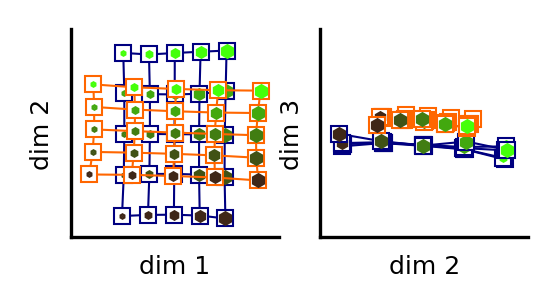

In [8]:
with open(data_dir + 'mds_embedding_DLPFC.pickle','rb') as f:
        xyz = pickle.load(f)
# # plot results
%matplotlib inline
xyz_rot = rotate(xyz,0,axis='x')
xyz_rot = rotate(xyz_rot,0,axis='y')
xyz_rot = rotate(xyz_rot,0,axis='z')

mm = 1/25.4
fig = plt.figure(1,figsize=(50*mm, 25*mm), dpi=300, facecolor='w', edgecolor='k')

plot_MDS_embeddings_2D(xyz_rot,fig,fig_id=1,axlims=.5,flipdims=True,flipcols=True)

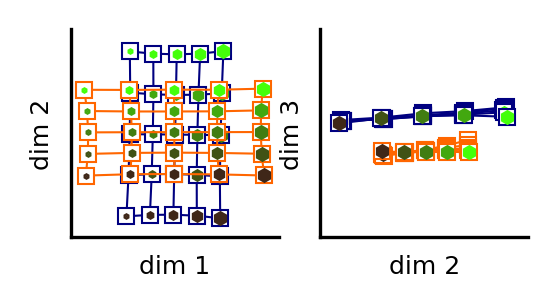

In [9]:
with open(data_dir + 'mds_embedding_ppc.pickle','rb') as f:
        xyz = pickle.load(f)
# plot results
%matplotlib inline
xyz_rot = rotate(xyz,0,axis='x')
xyz_rot = rotate(xyz_rot,0,axis='y')
xyz_rot = rotate(xyz_rot,0,axis='z')

mm = 1/25.4
fig = plt.figure(2,figsize=(50*mm, 25*mm), dpi=300, facecolor='w', edgecolor='k')

plot_MDS_embeddings_2D(xyz_rot,fig,fig_id=2,axlims=.5,flipdims=True,flipcols=True)

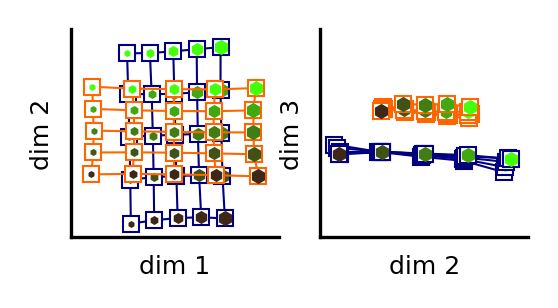

In [10]:
with open(data_dir + 'mds_embedding_mcc.pickle','rb') as f:
        xyz = pickle.load(f)
# plot results
%matplotlib inline
xyz_rot = rotate(xyz,0,axis='x')
xyz_rot = rotate(xyz_rot,0,axis='y')
xyz_rot = rotate(xyz_rot,0,axis='z')

mm = 1/25.4
fig = plt.figure(2,figsize=(50*mm, 25*mm), dpi=300, facecolor='w', edgecolor='k')

plot_MDS_embeddings_2D(xyz_rot,fig,fig_id=2,axlims=.5,flipdims=True,flipcols=True)

EVC Compression North: z=2.25, p=0.0242, Compression South: z=4.10, p=0.0000 
EVC Offset: z=4.86, p=0.0000 
EVC Angle: z=1.49, p=0.1364 
PPC Compression North: z=4.80, p=0.0000, Compression South: z=4.84, p=0.0000 
PPC Offset: z=4.86, p=0.0000 
PPC Angle: z=0.53, p=0.5967 
MCC Compression North: z=4.84, p=0.0000, Compression South: z=4.80, p=0.0000 
MCC Offset: z=4.86, p=0.0000 
MCC Angle: z=0.27, p=0.7838 
dlPFC Compression North: z=4.53, p=0.0000, Compression South: z=4.86, p=0.0000 
dlPFC Offset: z=4.86, p=0.0000 
dlPFC Angle: z=1.14, p=0.2557 


## 4D: fMRI brainbehav corrs

In [25]:
data_dir = dir_results_humanfmri + 'ROIs/'

In [26]:
# load behav data
behav_scores = loadmat(dir_results_humanbehav + 'behav_task_factorisation_betas.mat')['behav_scores']

Text(0.4, 0.07, 'p=0.457')

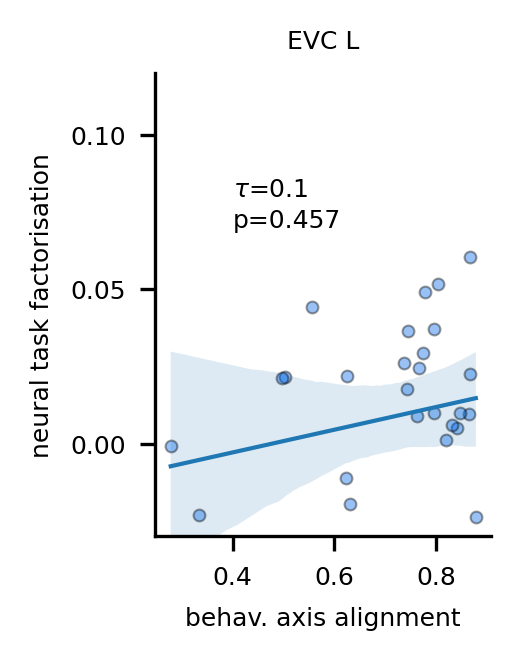

In [28]:
#1. left evc 
# load data 
neuro_scores = loadmat(data_dir + 'neuro_task_factorisation_all7mods_leftEVC.mat')['neuro_scores']

data_dict = {'x':behav_scores.flatten(),'y':neuro_scores.flatten()}
data = pd.DataFrame(data_dict)

mm = 1/25.4
%matplotlib inline
f = plt.figure(figsize=(55*mm,60*mm),dpi=300)
ax = plt.gca()

_ = sns.regplot(x='x',y='y',data=data,x_ci='ci',ci=95,ax=ax,scatter=False,line_kws={'linewidth':1})
sns.despine()

plt.scatter(data_dict['x'],data_dict['y'],color=(0,.4,.9),alpha=0.4,s=8,edgecolors='k',linewidth=0.5)
plt.xlabel('behav. axis alignment',fontsize=6)
plt.ylabel('neural task factorisation',fontsize=6)
plt.title('EVC L',fontsize=6)
plt.tight_layout()
t,p = kendalltau(behav_scores,neuro_scores)
t = np.round(t,2)
p = np.round(p,3)
plt.ylim([-0.03,0.12])
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xticks([.4,.6,.8])
plt.text(0.4,0.08,r'$\tau$=' + str(t),fontsize=6)
plt.text(0.4,0.07,'p=' + str(p),fontsize=6)


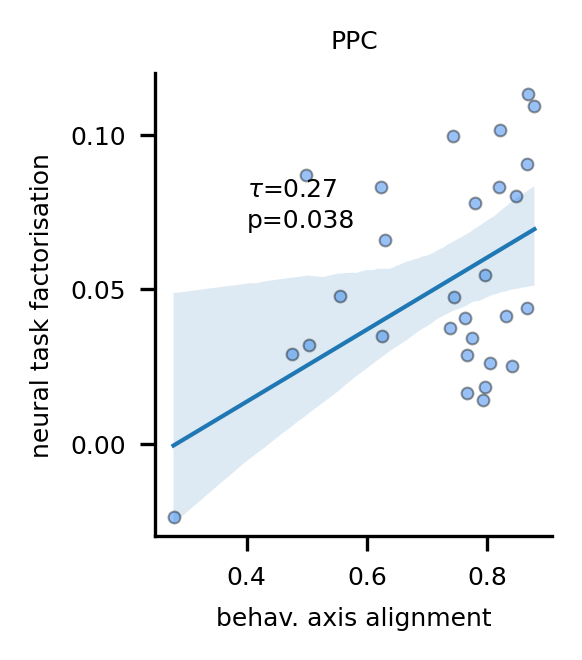

In [30]:
#2. parietal 
# load data 
neuro_scores = loadmat(data_dir + 'neuro_task_factorisation_all7mods_rightPAR.mat')['neuro_scores']

data_dict = {'x':behav_scores.flatten(),'y':neuro_scores.flatten()}
data = pd.DataFrame(data_dict)
mm = 1/25.4
%matplotlib inline
f = plt.figure(figsize=(55*mm,60*mm),dpi=300)
ax = plt.gca()

_ = sns.regplot(x='x',y='y',data=data,x_ci='ci',ci=95,ax=ax,scatter=False,line_kws={'linewidth':1})


plt.scatter(data_dict['x'],data_dict['y'],color=(0,.4,.9),alpha=0.4,s=8,edgecolors='k',linewidth=0.5)
plt.xlabel('behav. axis alignment',fontsize=6)
plt.ylabel('neural task factorisation',fontsize=6)
plt.title('PPC',fontsize=6)
plt.tight_layout()
t,p = kendalltau(behav_scores,neuro_scores)
t = np.round(t,2)
p = np.round(p,3)
plt.ylim([-0.03,0.12])
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xticks([.4,.6,.8])
plt.text(0.4,0.08,r'$\tau$=' + str(t),fontsize=6)
plt.text(0.4,0.07,'p=' + str(p),fontsize=6)
sns.despine()


Text(0.4, 0.07, 'p=0.003')

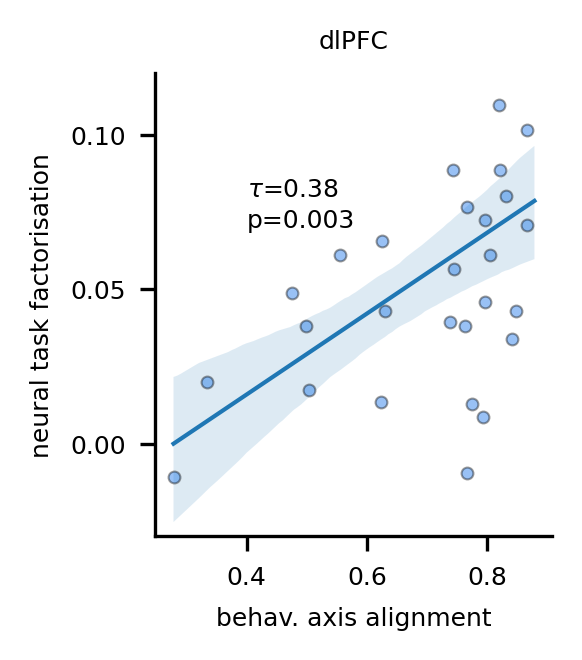

In [31]:
#3. dlpfc 
# load data 
neuro_scores = loadmat(data_dir + 'neuro_task_factorisation_all7mods_rightDLPFC.mat')['neuro_scores']

data_dict = {'x':behav_scores.flatten(),'y':neuro_scores.flatten()}
data = pd.DataFrame(data_dict)
mm = 1/25.4
%matplotlib inline
f = plt.figure(figsize=(55*mm,60*mm),dpi=300)
ax = plt.gca()

_ = sns.regplot(x='x',y='y',data=data,x_ci='ci',ci=95,ax=ax,scatter=False,line_kws={'linewidth':1})
sns.despine()

plt.scatter(data_dict['x'],data_dict['y'],color=(0,.4,.9),alpha=0.4,s=8,edgecolors='k',linewidth=0.5)
plt.xlabel('behav. axis alignment',fontsize=6)
plt.ylabel('neural task factorisation',fontsize=6)
plt.title('dlPFC',fontsize=6)
plt.tight_layout()
t,p = kendalltau(behav_scores,neuro_scores)
t = np.round(t,2)
p = np.round(p,3)
plt.ylim([-0.03,0.12])
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xticks([.4,.6,.8])
plt.text(0.4,0.08,r'$\tau$=' + str(t),fontsize=6)
plt.text(0.4,0.07,'p=' + str(p),fontsize=6)

Text(0.4, 0.07, 'p=0.005')

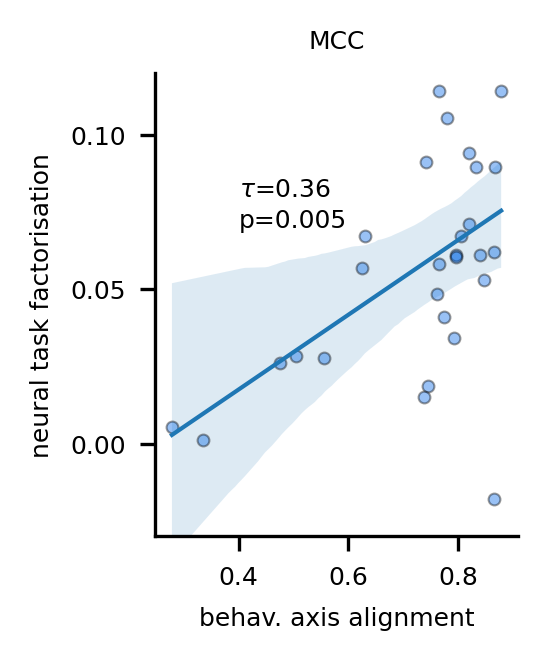

In [32]:
#3. MCC 
# load data 
neuro_scores = loadmat(data_dir + 'neuro_task_factorisation_all7mods_rightMCC.mat')['neuro_scores']

data_dict = {'x':behav_scores.flatten(),'y':neuro_scores.flatten()}
data = pd.DataFrame(data_dict)
mm = 1/25.4
%matplotlib inline
f = plt.figure(figsize=(55*mm,60*mm),dpi=300)
ax = plt.gca()

_ = sns.regplot(x='x',y='y',data=data,x_ci='ci',ci=95,ax=ax,scatter=False,line_kws={'linewidth':1})
sns.despine()

plt.scatter(data_dict['x'],data_dict['y'],color=(0,.4,.9),alpha=0.4,s=8,edgecolors='k',linewidth=0.5)
plt.xlabel('behav. axis alignment',fontsize=6)
plt.ylabel('neural task factorisation',fontsize=6)
plt.title('MCC',fontsize=6)
plt.tight_layout()
t,p = kendalltau(behav_scores,neuro_scores)
t = np.round(t,2)
p = np.round(p,3)
plt.ylim([-0.03,0.12])
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xticks([.4,.6,.8])
plt.text(0.4,0.08,r'$\tau$=' + str(t),fontsize=6)
plt.text(0.4,0.07,'p=' + str(p),fontsize=6)

## 4E: fMRI ROI RSA

EVC:
Grid: 	 t= 3.46, 	 p= 0.0008
Rotated Grid: 	 t= 0.93, 	 p= 0.1809
Orthogonal: 	 t= 1.76, 	 p= 0.0442
Parallel: 	 t= -0.75, 	 p= 0.7692
Branchiness: 	 t= 4.74, 	 p= 0.0000
Leafiness: 	 t= -3.43, 	 p= 0.9991
Diagonal: 	 t= -1.20, 	 p= 0.8805
dlPFC:
Grid: 	 t= 0.60, 	 p= 0.2758
Rotated Grid: 	 t= -0.19, 	 p= 0.5746
Orthogonal: 	 t= 8.18, 	 p= 0.0000
Parallel: 	 t= -1.31, 	 p= 0.8999
Branchiness: 	 t= 0.19, 	 p= 0.4259
Leafiness: 	 t= -1.59, 	 p= 0.9388
Diagonal: 	 t= -1.28, 	 p= 0.8949
MCC:
Grid: 	 t= 1.08, 	 p= 0.1448
Rotated Grid: 	 t= 0.82, 	 p= 0.2093
Orthogonal: 	 t= 7.17, 	 p= 0.0000
Parallel: 	 t= -1.88, 	 p= 0.9648
Branchiness: 	 t= -0.50, 	 p= 0.6908
Leafiness: 	 t= -1.26, 	 p= 0.8914
Diagonal: 	 t= -2.18, 	 p= 0.9815
PPC:
Grid: 	 t= 1.31, 	 p= 0.1007
Rotated Grid: 	 t= -0.56, 	 p= 0.7086
Orthogonal: 	 t= 7.77, 	 p= 0.0000
Parallel: 	 t= -1.41, 	 p= 0.9149
Branchiness: 	 t= -0.35, 	 p= 0.6354
Leafiness: 	 t= -2.19, 	 p= 0.9816
Diagonal: 	 t= -2.73, 	 p= 0.9947


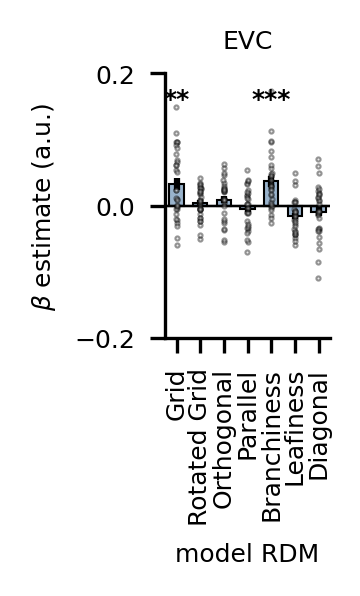

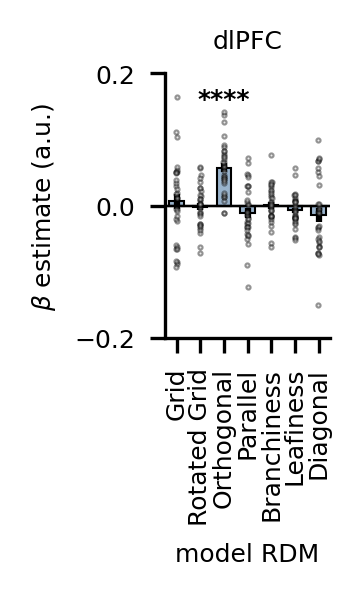

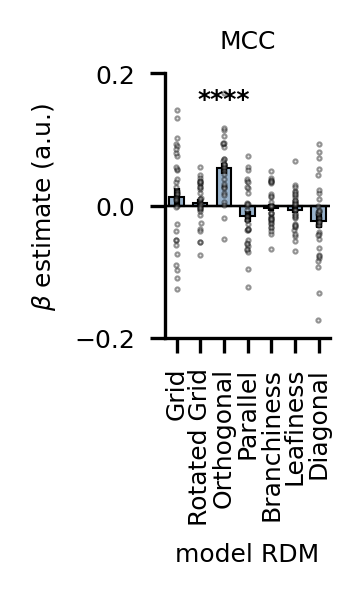

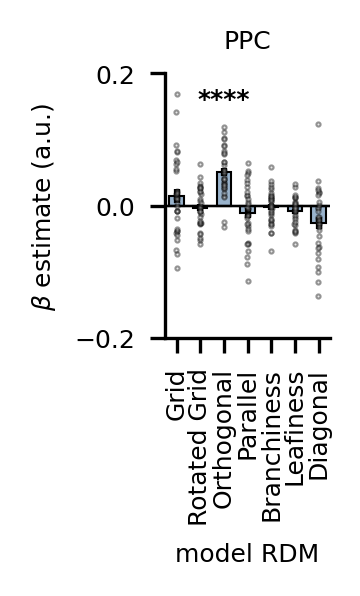

In [36]:
datadir = dir_results_humanfmri + 'ROIs/'
betas = loadmat(datadir+'allbetas_group_rois_toplot.mat')
betas.keys()
betas['betas_evc'] = betas['betas_leftevc']


SMALL_SIZE = 6
MEDIUM_SIZE = 6
BIGGER_SIZE = 6

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plot_roi_betas(betas['betas_evc'],titlestr='EVC')
plt.tight_layout()
plot_roi_betas(betas['betas_dlpfc'],titlestr='dlPFC')
plt.tight_layout()
plot_roi_betas(betas['betas_mcc'],titlestr='MCC')
plt.tight_layout()
plot_roi_betas(betas['betas_ppc'],titlestr='PPC')
plt.tight_layout()

## 4F: Monkey MDS

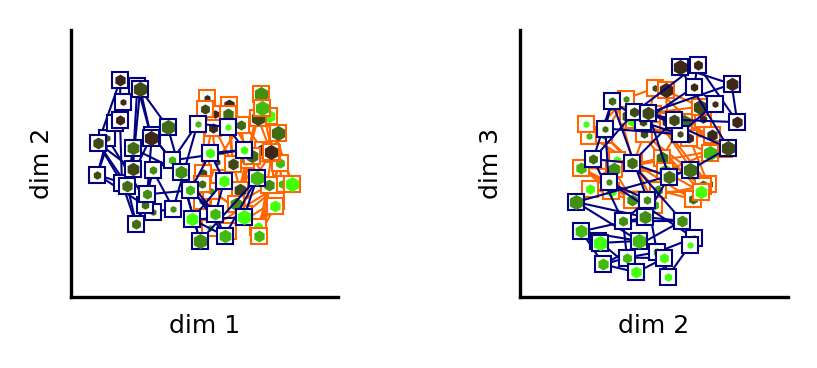

In [68]:
data = loadmat(dir_results_monkeys + 'paper_mante_monkeyA_rdms.mat')
dmat = data['rdms_monkeyA'][0][0][0]
rdm =  data['rdms_monkeyA'][0][0][1]
embedding = MDS(n_components=3,dissimilarity='precomputed',metric=True)
xyz = embedding.fit_transform(rdm)


%matplotlib inline
xyz_rot = rotate(xyz,0,axis='x')
xyz_rot = rotate(xyz_rot,0,axis='y')
xyz_rot = rotate(xyz_rot,0,axis='z')

mm = 1/25.4
fig = plt.figure(1,figsize=(90*mm, 30*mm), dpi=300, facecolor='w', edgecolor='k')

plot_MDS_embeddings_2D(xyz_rot,fig,fig_id=1,axlims=.5,flipdims=True,monk=True)

for ii in range(1,3):
    plt.subplot(1,2,ii)
    plt.xlim((-.2,.2))
    plt.ylim((-.2,.2))



## 4G Monkey RSA

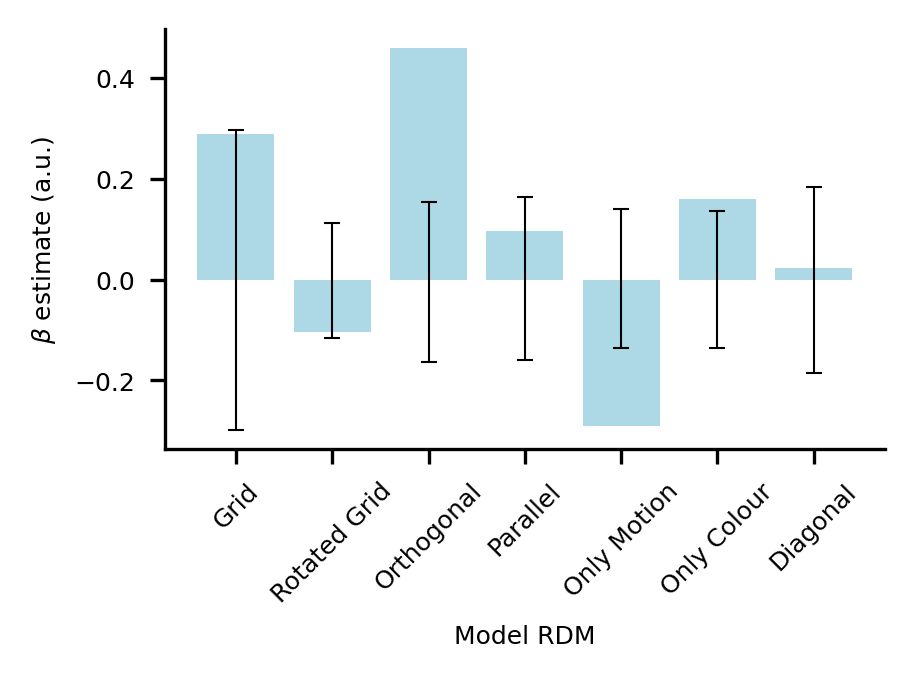

In [105]:
#todo
betas = loadmat(dir_results_monkeys + 'paper_mante_monkeyA_betas.mat')
betas_perm = loadmat(dir_results_monkeys + 'paper_mante_monkeyA_betas_perm.mat')
b = betas['betas'].flatten()
bp = betas_perm['betas_perm']

mm = 1/25.4
f =plt.figure(1,figsize=(80*mm,60*mm),dpi=300)
plt.bar(np.arange(7),b,color='lightblue',edgecolor=None,linewidth=0.5)
for ii in range(7):
    plt.errorbar(ii,np.mean(bp[:,ii],0),np.std(bp[:,ii],0)*2,color='k',capsize=2,elinewidth=0.5,capthick=0.5)
plt.xlabel('Model RDM')
plt.ylabel(r'$\beta$ estimate (a.u.)')
plt.xticks(ticks=np.arange(7),labels=['Grid','Rotated Grid', 'Orthogonal','Parallel','Only Motion','Only Colour','Diagonal'],rotation=45)
sns.despine()
plt.tight_layout()

# Figure 5

## 5B: Gating Theory

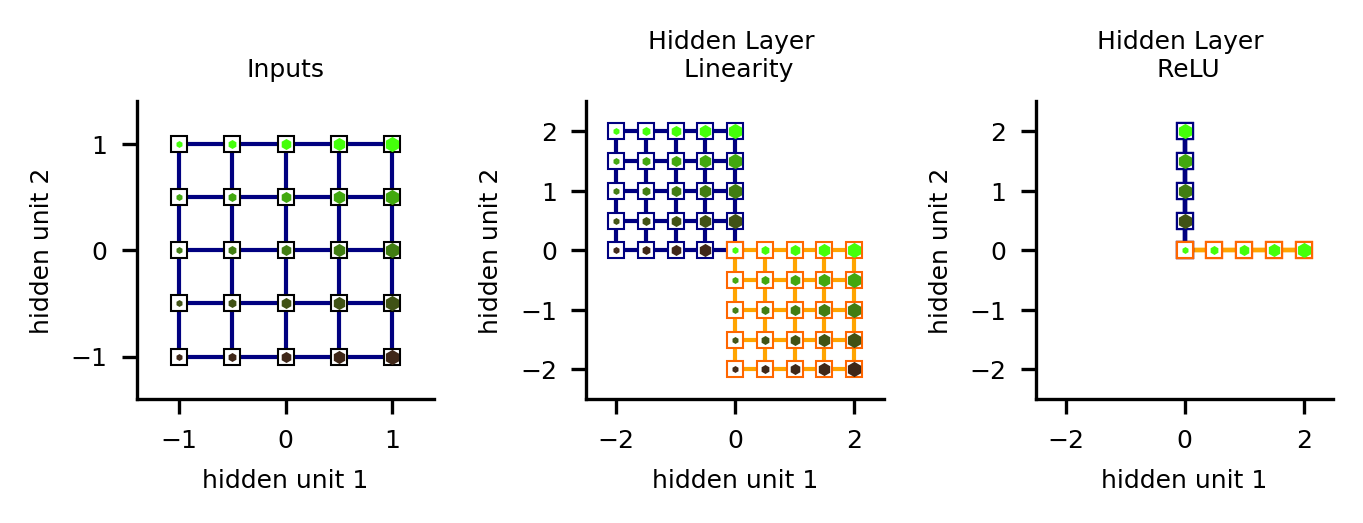

In [113]:
# subplots: centered grid, displaced grids, relu gate, relu gate with gradient
a,b = np.meshgrid(np.linspace(-1,1,5),np.linspace(-1,1,5))
a = a.flatten()
b = b.flatten()
xyz = np.stack((a,b),axis=1)

mm = 1/25.4
plt.figure(1, figsize=(120*mm,60*mm),dpi=300)
# input space 
plt.subplot(1,3,1)
plot_grid2(xyz[0:25,],line_colour=(0, 0, .5),fig_id=1)
scatter_mds_2(xyz,fig_id=1,task_id='avg')
plt.xlabel('hidden unit 1',fontsize=6)
plt.ylabel('hidden unit 2',fontsize=6)
plt.title('Inputs',fontsize=6)
plt.xlim(-1.4,1.4)
plt.ylim(-1.4,1.4)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
ax = plt.gca()
ax.set_aspect('equal','box')

# hidden layer, linearity 
plt.subplot(1,3,2)
xyz1 = np.copy(xyz)
xyz1[:,0] -=1
xyz1[:,1] +=1
xyz2 = np.copy(xyz)
xyz2[:,1] -=1
xyz2[:,0] +=1
plot_grid2(xyz1,line_colour=(0, 0, .5),fig_id=1)
plot_grid2(xyz2,line_colour='orange',fig_id=1)
scatter_mds_2(xyz1,fig_id=1,task_id='b',flipdims=False)
scatter_mds_2(xyz2,fig_id=1,task_id='a',flipdims=False)
plt.xlabel('hidden unit 1',fontsize=6)
plt.ylabel('hidden unit 2',fontsize=6)
plt.title('Hidden Layer \n Linearity',fontsize=6)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
ax = plt.gca()
ax.set_aspect('equal','box')

# hidden layer, ReLU
plt.subplot(1,3,3)
plot_grid2(np.maximum(0,xyz1),line_colour=(0, 0, .5),fig_id=1)
plot_grid2(np.maximum(0,xyz2),line_colour='orange',fig_id=1)
scatter_mds_2(np.maximum(0,xyz1),fig_id=1,task_id='b',flipdims=False)
scatter_mds_2(np.maximum(0,xyz2),fig_id=1,task_id='a',flipdims=False)
plt.xlabel('hidden unit 1',fontsize=6)
plt.ylabel('hidden unit 2',fontsize=6)
plt.title('Hidden Layer \n ReLU',fontsize=6)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
ax = plt.gca()
ax.set_aspect('equal','box')


ax = plt.gca()
ax.set_aspect('equal','box')
plt.tight_layout()
sns.despine()

# Figure 6

## 6A: Average Unit Selectivity

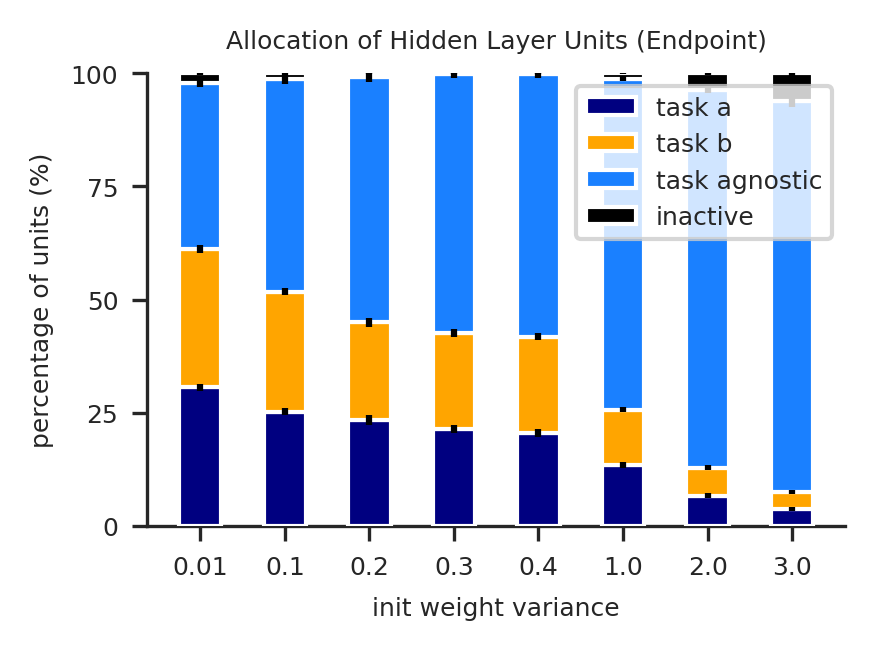

In [148]:
# load data
N_STIM = 25
N_CTX = 2
N_HIDDEN = 100
N_OUT = 1
N_RUNS = 20
N_ITER = 10000
LRATE = 5e-3
SCALE_WHXS = np.asarray([1e-2,1e-1,2e-1,3e-1,4e-1,1,2,3])

N_FACTORS = len(SCALE_WHXS)
scale_labels = [str(ii) for ii in SCALE_WHXS]

with open(dir_results_simus + 'results_mlp_gating.pkl','rb') as f:
        results = pickle.load(f)


# Sparsity of hidden layer - endpoint
%matplotlib inline
plt.figure(figsize=(3,2),dpi=300)
# task A and b units
coeffs_mu_a = np.mean(results['n_only_a'][:,:,1],1)/N_HIDDEN
coeffs_err_a = np.std(results['n_only_a'][:,:,1],1)/np.sqrt(results['n_only_a'][:,:,1].shape[1])
coeffs_err_a /= np.asarray(N_HIDDEN)
ha = plt.bar(np.arange(0,coeffs_mu_a.shape[0]),coeffs_mu_a,color=(0, 0,0.5),yerr=coeffs_err_a,width=0.5,zorder=3)


coeffs_mu_b = np.mean(results['n_only_b'][:,:,1],1)/N_HIDDEN
coeffs_err_b = np.std(results['n_only_b'][:,:,1],1)/np.sqrt(results['n_only_b'][:,:,1].shape[1])
coeffs_err_b /= np.asarray(N_HIDDEN)
hb = plt.bar(np.arange(0,coeffs_mu_b.shape[0]),coeffs_mu_b,color='orange',bottom=coeffs_mu_a,width=0.5,yerr=coeffs_err_b,zorder=3)


coeffs_mu_m = np.mean(N_HIDDEN-results['n_local'][:,:,1]-results['n_dead'][:,:,1],1)/N_HIDDEN
coeffs_err_m = np.std(N_HIDDEN-results['n_local'][:,:,1]-results['n_dead'][:,:,1],1)/np.sqrt(results['n_dead'][:,:,1].shape[1])
coeffs_err_m /= np.asarray(N_HIDDEN)
hm = plt.bar(np.arange(0,coeffs_mu_m.shape[0]),coeffs_mu_m,color=(0.1,0.5,1),bottom=coeffs_mu_b+coeffs_mu_a,width=0.5,yerr=coeffs_err_m,zorder=3)


coeffs_mu_d = np.mean(results['n_dead'][:,:,1],1)/N_HIDDEN
coeffs_err_d = np.std(results['n_dead'][:,:,1],1)/np.sqrt(results['n_dead'][:,:,1].shape[1])
coeffs_err_d /= np.asarray(N_HIDDEN)
hd = plt.bar(np.arange(0,coeffs_mu_d.shape[0]),coeffs_mu_d,color=[0,0,0],bottom=coeffs_mu_m+coeffs_mu_b+coeffs_mu_a,width=0.5,yerr=coeffs_err_d,zorder=3)

plt.legend([ha,hb,hm,hd],['task a', 'task b','task agnostic', 'inactive'],fontsize=6,frameon=True,loc=1)
plt.ylim([0,1])

plt.yticks(ticks=np.arange(0,1.25,.25))
plt.yticks(ticks=np.arange(0,1.25,.25),labels=tuple((plt.yticks()[0]*100).astype('int')))
plt.xticks(ticks=np.arange(0,coeffs_mu_a.shape[0]),labels=scale_labels)
plt.ylabel('percentage of units (%)',fontsize=6)
plt.xlabel('init weight variance',fontsize=6)

plt.title('Allocation of Hidden Layer Units (Endpoint)',fontsize=6)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


## 6B-D: Context Weight Correlations

In [145]:
# load data
N_STIM = 25
N_CTX = 2
N_HIDDEN = 100
N_OUT = 1
N_RUNS = 30
N_ITER = 10000
LRATE = 5e-3
SCALE_WHXS = np.asarray([1e-2,1e-1,2e-1,3e-1,4e-1,1,2,3])

N_FACTORS = len(SCALE_WHXS)
scale_labels = [str(ii) for ii in SCALE_WHXS]
# open results (was 'results_nnet_main_withacc_withmlp_stepscaled.pickle)
with open(dir_results_simus+'/results_mlp_main.pkl','rb') as f:
        results = pickle.load(f)
        
%matplotlib qt
cmap = sns.color_palette("crest", as_cmap=True).colors
sns.set_style('ticks')
corrs = np.empty((4,2,8,N_RUNS))
for ii in range(8):
    for jj in range(N_RUNS):
        yout = results['all_y_hidden'][ii,jj,:,:]
        x = np.vstack((np.nanmean(yout[:,0:25],1).T,np.nanmean(yout[:,25:],1).T))
        # local units
        mask_local = ~(np.all(x,axis=0)) & np.any(x,axis=0)
        mask_a = np.all(np.vstack((x[0,:]>0,x[1,:]==0)),axis=0)
        mask_b = np.all(np.vstack((x[0,:]==0,x[1,:]>0)),axis=0) 
        corrs[0,0,ii,jj] = np.corrcoef(results['w_hxc_0'][ii,jj,mask_local==1,:].T)[0,1]
        corrs[0,1,ii,jj] = np.corrcoef(results['all_w_hxc'][ii,jj,mask_local==1,:].T)[0,1]
        corrs[1,0,ii,jj] = np.corrcoef(results['w_hxc_0'][ii,jj,~mask_local==1,:].T)[0,1]
        corrs[1,1,ii,jj] = np.corrcoef(results['all_w_hxc'][ii,jj,~mask_local==1,:].T)[0,1]
        corrs[2,0,ii,jj] = np.corrcoef(results['w_hxc_0'][ii,jj,:,:].T)[0,1]
        corrs[2,1,ii,jj] = np.corrcoef(results['all_w_hxc'][ii,jj,:,:].T)[0,1]
        
# d = pd.DataFrame(data=corrs[0,:,:].T,index=['run ' + str(i) for i in range(len(corrs[0,:,:].T))],columns=['sigma '+ str(i) for i in range(len(corrs[0,:,:]))])

plt.figure(figsize=(10,3))
# all
plt.subplot(1,3,1)
a1 = sns.kdeplot(data=corrs[2,0,0,:],fill=False, linewidth=1,color='k',linestyle='--',label='init')
a2 = sns.kdeplot(data=corrs[2,0,0,:],fill=True,alpha=.2, linewidth=0,color=cmap[0])
b1 = sns.kdeplot(data=corrs[2,1,0,:],fill=False, linewidth=2,color='k',linestyle='-',label='endpoint')
b2 = sns.kdeplot(data=corrs[2,1,0,:],fill=True,alpha=.8, linewidth=0,color=cmap[0])
plt.plot([corrs[2,0,0,:],corrs[2,0,0,:]],[0,1],'k',linestyle=':')
plt.plot([corrs[2,1,0,:],corrs[2,1,0,:]],[0,1],'k')
plt.xlabel('correlation of ctx weights')
plt.xlim(-1,1)
plt.ylim(0,7)
plt.title('All Units',fontweight='normal')
plt.legend(frameon=False)
# local 
plt.subplot(1,3,2)
a1 = sns.kdeplot(data=corrs[0,0,0,:],fill=False, linewidth=1,color='k',linestyle='--',label='init')
a2 = sns.kdeplot(data=corrs[0,0,0,:],fill=True,alpha=.2, linewidth=0,color=cmap[100])
b1 = sns.kdeplot(data=corrs[0,1,0,:],fill=False, linewidth=2,color='k',linestyle='-',label='endpoint')
b2 = sns.kdeplot(data=corrs[0,1,0,:],fill=True,alpha=.8, linewidth=0,color=cmap[100])
plt.plot([corrs[0,0,0,:],corrs[0,0,0,:]],[0,1],'k',linestyle=':')
plt.plot([corrs[0,1,0,:],corrs[0,1,0,:]],[0,1],'k')
plt.xlabel('correlation of ctx weights')
plt.xlim(-1,1)
plt.ylim(0,7)
plt.title('Only Task Selective Units',fontweight='normal')
plt.legend(frameon=False)
# mixed units 
plt.subplot(1,3,3)
a1 = sns.kdeplot(data=corrs[1,0,0,:],fill=False, linewidth=1,color='k',linestyle='--',label='init')
a2 = sns.kdeplot(data=corrs[1,0,0,:],fill=True,alpha=.2, linewidth=0,color=cmap[210])
b1 = sns.kdeplot(data=corrs[1,1,0,:],fill=False, linewidth=2,color='k',linestyle='-',label='endpoint')
b2 = sns.kdeplot(data=corrs[1,1,0,:],fill=True,alpha=.8, linewidth=0,color=cmap[210])
plt.plot([corrs[1,0,0,:],corrs[1,0,0,:]],[0,1],'k',linestyle=':')
plt.plot([corrs[1,1,0,:],corrs[1,1,0,:]],[0,1],'k')
plt.xlabel('correlation of ctx weights')
plt.xlim(-1,1)
plt.ylim(0,7)
plt.title('Only Mixed Selective Units',fontweight='normal')
plt.legend(frameon=False)


sns.despine()

plt.tight_layout()


## 6E: Monkey Unit Selectivity

## 6F: Unit Heatmaps

## 6G: Unit RSA

## 6H: Ablation Study

## 6I: Monkey Unit Heatmaps

## 6J: Monkey Unit RSA

# Panel 3

## 3b: Gating Theory 

## Fig 3e: Hidden Layer Partitioning

## 3F-H: Context Weight correlations

## 3I Average tuning profile

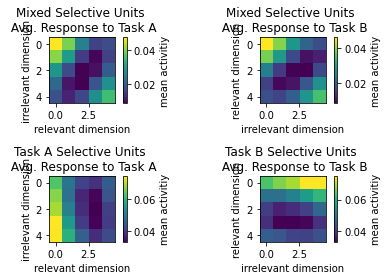

In [10]:
# load data
N_STIM = 25
N_CTX = 2
N_HIDDEN = 100
N_OUT = 1
N_RUNS = 30
N_ITER = 10000
LRATE = 5e-3
SCALE_WHXS = np.asarray([1e-2,1e-1,2e-1,3e-1,4e-1,1,2,3])

N_FACTORS = len(SCALE_WHXS)
scale_labels = [str(ii) for ii in SCALE_WHXS]
# open results (was 'results_nnet_main_withacc_withmlp_stepscaled.pickle)
# with open('/media/timo/data/DPHIL_01_TREES_FMRI/Paper/code/Data/Simulations/mlp/results_nnet_main_withacc_withmlp_stepscaled.pickle','rb') as f:
with open('/media/timo/data/DPHIL_01_TREES_FMRI/Paper/code/Experiments/Simulations/results_mlp_main.pkl','rb') as f:
    results = pickle.load(f)

y_mixed = np.empty((N_RUNS,50))
y_local = np.empty((N_RUNS,50))


for ii in range(N_RUNS):
    yout = results['all_y_hidden'][0,ii,:,:]
    x = np.vstack((np.nanmean(yout[:,0:25],1).T,np.nanmean(yout[:,25:],1).T))
    # local units
    mask_local = ~(np.all(x,axis=0)) & np.any(x,axis=0)
    mask_a = np.all(np.vstack((x[0,:]>0,x[1,:]==0)),axis=0)
    mask_b = np.all(np.vstack((x[0,:]==0,x[1,:]>0)),axis=0)    
    y_local[ii,:] =np.concatenate((np.nanmean(yout[mask_a,:25],0),np.nanmean(yout[mask_b,25:],0)),axis=0)
    # mixed units: not local
    mask_mixed = np.all(x,axis=0)#~mask_local 
    y_mixed[ii,:] = np.nanmean(yout[mask_mixed,:],0)
plt.figure()
plt.subplot(2,2,1)
plt.imshow(np.nanmean(y_mixed[:,:25],0).reshape(5,5),cmap='viridis')
plt.title('Mixed Selective Units \n Avg. Response to Task A')
plt.xlabel('relevant dimension')
plt.ylabel('irrelevant dimension')
# plt.clim(0,0.05)
plt.colorbar(label='mean activitiy')

plt.subplot(2,2,2)
plt.imshow(np.nanmean(y_mixed[:,25:],0).reshape(5,5),cmap='viridis')
plt.title('Mixed Selective Units \n Avg. Response to Task B')
plt.xlabel('irrelevant dimension')
plt.ylabel('relevant dimension')
# plt.clim(0,0.05)
plt.colorbar(label='mean activitiy')

plt.subplot(2,2,3)
plt.imshow(np.nanmean(y_local[:,:25],0).reshape(5,5),cmap='viridis')
plt.title('Task A Selective Units \n Avg. Response to Task A')
plt.xlabel('relevant dimension')
plt.ylabel('irrelevant dimension')
# plt.clim(0,0.07)
plt.colorbar(label='mean activitiy')
plt.subplot(2,2,4)
plt.imshow(np.nanmean(y_local[:,25:],0).reshape(5,5),cmap='viridis')
plt.title('Task B Selective Units \n Avg. Response to Task B')
plt.xlabel('irrelevant dimension')
plt.ylabel('relevant dimension')
# plt.clim(0,0.07)
plt.colorbar(label='mean activitiy')

plt.tight_layout()


## 3J Unit Axis Alignment

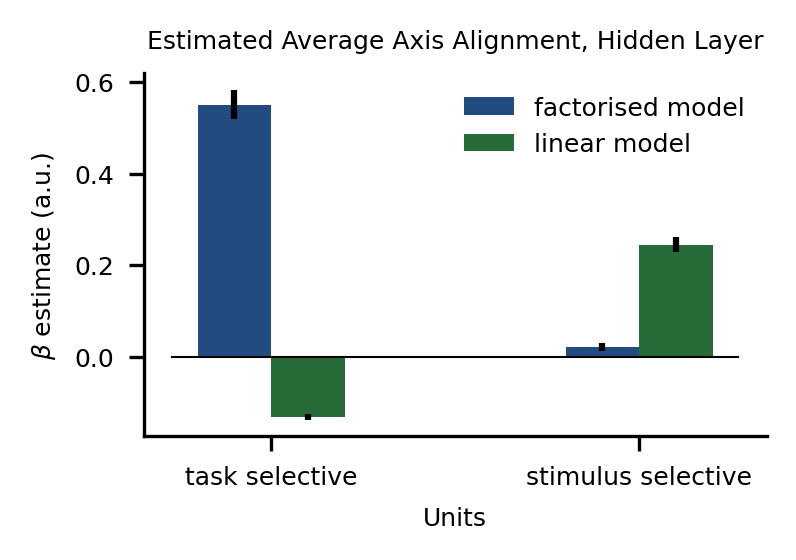

In [17]:
def gen_behav_models():
    modelrdms = np.empty((2,50,50))
    # factorised model:
    a,b = np.meshgrid(np.linspace(-2,2,5),np.linspace(-2,2,5))
    x = np.concatenate((a.flatten(),b.flatten()),axis=0)[:,np.newaxis]
    modelrdms[0,:,:] = squareform(pdist(x))
    
    # diagonal model 
    x1 = np.zeros((5,5))
    for ii in range(0,3):
        x1[np.triu_indices(5,k=ii)] = ii
    x1 = np.flipud(np.tril(np.flipud(np.fliplr(np.triu(x1))))*-1 + x1)    
    x = np.concatenate((x1.flatten(),x1.flatten()),axis=0)[:,np.newaxis]    
    modelrdms[1,:,:] = squareform(pdist(x))
   
    rdm1 = modelrdms[0,:,:]
    rdm2 = modelrdms[1,:,:]

    dmat = np.array([zscore(rdm1[np.tril_indices(50,k=-1)].flatten()),zscore(rdm2[np.tril_indices(50,k=-1)].flatten())]).T
    return modelrdms,dmat


def gen_activitymats(results):
    y_mixed = np.empty((N_RUNS,50))
    y_local = np.empty((N_RUNS,50))


    for ii in range(N_RUNS):
        yout = results['all_y_hidden'][0,ii,:,:]
        x = np.vstack((np.nanmean(yout[:,0:25],1).T,np.nanmean(yout[:,25:],1).T))
        # local units
        mask_local = ~(np.all(x,axis=0)) & np.any(x,axis=0)
        mask_a = np.all(np.vstack((x[0,:]>0,x[1,:]==0)),axis=0)
        mask_b = np.all(np.vstack((x[0,:]==0,x[1,:]>0)),axis=0)    
        y_local[ii,:] =np.concatenate((np.nanmean(yout[mask_a,:25],0),np.nanmean(yout[mask_b,25:],0)),axis=0)
        # mixed units: not local
        mask_mixed = np.all(x,axis=0)#~mask_local 
        y_mixed[ii,:] = np.nanmean(yout[mask_mixed,:],0)
    return y_local, y_mixed
# gen_behav_models(1)

# gen average unit activity matrices
y_local,y_mixed = gen_activitymats(results)
# generate and display model matrices 
modrdms,dmat = gen_behav_models()
# loop over runs and regress activity rdms against model rdms
regr = linear_model.LinearRegression()
betas_task = []
betas_mixed = []
for ii in range(y_local.shape[0]):
    # construct rdm 
    yt = zscore(squareform(pdist(y_local[ii,:].reshape((-1,50)).T))[np.tril_indices(50,k=-1)].flatten())
    ym = zscore(squareform(pdist(y_mixed[ii,:].reshape((-1,50)).T))[np.tril_indices(50,k=-1)].flatten())
    regr.fit(dmat,yt)
    betas_task.append(regr.coef_)
    regr.fit(dmat,ym)
    betas_mixed.append(regr.coef_)
betas_task = np.asarray(betas_task)
betas_mixed = np.asarray(betas_mixed)   
# display beta values 
betas_mu = np.stack((np.mean(betas_task,0),np.mean(betas_mixed,0)),axis=0)
betas_err = np.stack((np.std(betas_task,0),np.std(betas_mixed,0)),axis=0)/(N_RUNS**.5)

# plot results


mm = 1/25.4
f,ax = plt.subplots(figsize=(70*mm,50*mm),dpi=300) 
width=0.2
b1 = plt.bar(np.asarray([1,2])-width/2,betas_mu[:,0],width,yerr=betas_err[:,0],color=(34/255, 76/255, 128/255))
b2 = plt.bar(np.asarray([1,2])+width/2,betas_mu[:,1],width,yerr=betas_err[:,1],color=(39/255, 107/255, 57/255))
plt.plot(plt.xlim(),np.asarray([0,0]),'k-',linewidth=.5)
ax.set_xticks(np.asarray([1,2]))
ax.set_xticklabels(['task selective','stimulus selective'],fontsize=6)
ax.set_xlabel('Units',fontsize=6)
ax.set_ylabel(r'$\beta$ estimate (a.u.)',fontsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend([b1,b2],['factorised model','linear model'],frameon=False,fontsize=6)
ax.set_title('Estimated Average Axis Alignment, Hidden Layer',fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
f.tight_layout()


In [37]:
betas = {'fact':betas_task,'mixed':betas_mixed}
from scipy.io import savemat
savemat('betas_model_unitfact.mat',betas)

## 3K Ablation Study

In [17]:

cmap = sns.color_palette("crest", as_cmap=True).colors
accs_mu = np.asarray([np.mean(results['acc_y_ref'][0,:]),np.mean(results['acc_y_local'][0,:]),np.mean(results['acc_y_mixed'][0,:])])
accs_err =np.asarray([np.std(results['acc_y_ref'][0,:])/np.sqrt(results['acc_y_ref'].shape[1]),np.std(results['acc_y_local'][0,:])/np.sqrt(results['acc_y_ref'].shape[1]),np.std(results['acc_y_mixed'][0,:])/np.sqrt(results['acc_y_ref'].shape[1])])

mm = 1/25.4
plt.figure(figsize=(60*mm,50*mm),dpi=300)
plt.bar(0,accs_mu[0],yerr=accs_err[0],color=cmap[0],width=0.6)
plt.bar(1,accs_mu[1],yerr=accs_err[1],color=cmap[100],width=0.6)
plt.bar(2,accs_mu[2],yerr=accs_err[2],color=cmap[210],width=0.6)
plt.title('Ablation Study: Accuracy',fontsize=6)
plt.xticks(ticks=np.arange(3),labels=('all','task sel.', 'stimulus sel.'),fontsize=6)
plt.xlabel('Retained Hidden Layer Units',fontsize=6)
plt.ylabel('Accuracy (%)',fontsize=6)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks(np.arange(0,1.1,0.25),labels=np.arange(0,110,25),fontsize=6)
plt.xticks(fontsize=6)
plt.ylim(.5,1)
plt.tight_layout()

## 3L Monkey Unit Responses

In [23]:
# matlab

## 3M Monkey Tuning Profiles

In [24]:
# matlab

## 3N Monkey Axis Alignment

In [114]:
%matplotlib qt

datadir= '/media/timo/data/DPHIL_01_TREES_FMRI/Paper/code/Results/Monkeys/'
results = loadmat(datadir+'unitselectivity_betas.mat')
betas_task = results['betas_task']
betas_mixed = results['betas_mixed']


# display beta values 
betas_mu = np.stack((np.mean(betas_task,0),np.mean(betas_mixed,0)),axis=0)
betas_err = np.stack((np.std(betas_task,0),np.std(betas_mixed,0)),axis=0)/(betas_mixed.shape[0]**.5)

# plot results


mm = 1/25.4
f,ax = plt.subplots(figsize=(70*mm,50*mm),dpi=300) 
width=0.2
b1 = plt.bar(np.asarray([1,2])-width/2,betas_mu[:,0],width,yerr=betas_err[:,0],color=(34/255, 76/255, 128/255))
b2 = plt.bar(np.asarray([1,2])+width/2,betas_mu[:,1],width,yerr=betas_err[:,1],color=(39/255, 107/255, 57/255))
plt.plot(plt.xlim(),np.asarray([0,0]),'k-',linewidth=.5)
ax.set_xticks(np.asarray([1,2]))
ax.set_xticklabels(['task specific','task agnostic'],fontsize=6)
ax.set_xlabel('Units',fontsize=6)
ax.set_ylabel(r'$\beta$ estimate (a.u.)',fontsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend([b1,b2],['factorised model','linear model'],frameon=False,fontsize=6)
ax.set_title('Estimated Average Axis Alignment, \n Monkey A',fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
f.tight_layout()
